<a href="https://colab.research.google.com/github/Wyw021214/ISP_autism/blob/main/Multireg_Actflow_NMA_data(Glasser_to_Craddock).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [1]:
# @title Install dependencies
!pip install numpy==1.23.5
!pip install nilearn actflow


INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.1/197.1 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 18.1 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.44.0
    Uninstalling llvmlite-0.44.0:
      Successfully uninstalled llvmlite-0.44.0
  Attempting uninstall: numba
    Found existing installation: numba 0.61.0
    Uninstalling numba-0.61.0:
      Successfully uninstalled numba-

In [1]:
!pip install --upgrade setuptools

import os
import numpy as np
import matplotlib.pyplot as plt

# Necessary for visualization
from nilearn import plotting, datasets

import h5py
import pkg_resources
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import sys
sys.path.insert(0, '../../')

#Used for plotting brain images inline
from wbplot import pscalar
import matplotlib.image as mpimg

import ActflowToolbox as actflow

<ipython-input-1-5541c21d8e7f>:11: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [3]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./DATA"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['mental','rnd']}
}


# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [4]:
# @title Download the data

# @markdown Task data in `HCP_DIR/hcp_task`, rest in `HCP_DIR/hcp_rest`, covariate in `HCP_DIR/hcp`

import os, requests, tarfile

fnames = ["hcp_rest.tgz",
          "hcp_task.tgz",
          "hcp_covariates.tgz",
          "atlas.npz"]
urls = ["https://osf.io/bqp7m/download",
        "https://osf.io/s4h8j/download",
        "https://osf.io/x5p4g/download",
        "https://osf.io/j5kuc/download"]

for fname, url in zip(fnames, urls):
  file_path=os.path.join(HCP_DIR, fname)

  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

Download hcp_rest.tgz completed!
Download hcp_task.tgz completed!
Download hcp_covariates.tgz completed!
Download atlas.npz completed!


In [5]:
# @title Extract the data in `HCP_DIR`
fnames = ["hcp_covariates", "hcp_rest", "hcp_task"]

for fname in fnames:
  # open file
  path_name = os.path.join(HCP_DIR, fname)
  if not os.path.exists(path_name):
    print(f"Extracting {fname}.tgz...")
    with tarfile.open(f"{fname}.tgz") as fzip:
      fzip.extractall(HCP_DIR)
  else:
    print(f"File {fname}.tgz has already been extracted.")

Extracting hcp_covariates.tgz...
Extracting hcp_rest.tgz...
Extracting hcp_task.tgz...


## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [6]:
dir = os.path.join(HCP_DIR, "hcp_task")  # choose the data directory
regions = np.load(os.path.join(dir, "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   myelin=regions[2].astype(float)
                   )

In [7]:
networkdef = regions[1]
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
netorder=networkorder[:,0]

We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [8]:
with np.load(f"atlas.npz") as dobj:
  atlas = dict(**dobj)

# Helper functions


## Data loading

In [9]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
             i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
             ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}'")
  return run_ids


def load_timeseries(subject, name, dir,
                    runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    dir (str) : data directory
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"   #file might have missing data
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, name, condition, dir):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition
    dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Task-based analysis

In [10]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

In [11]:
hcp_rest_dir = os.path.join(HCP_DIR, "hcp_rest")
print("Available files in hcp_rest:", os.listdir(hcp_rest_dir))

Available files in hcp_rest: ['._subjects', 'subjects', '._.DS_Store', '.DS_Store', 'regions.npy']


In [12]:
subjects_dir = os.path.join(HCP_DIR, "hcp_rest", "subjects")
print("Available subjects:", os.listdir(subjects_dir))

Available subjects: ['92', '._306', '._240', '._270', '68', '._217', '._258', '._286', '._287', '._143', '._77', '303', '337', '._51', '._253', '._151', '._205', '15', '._289', '242', '165', '._214', '._313', '._332', '._310', '157', '314', '271', '._156', '211', '._144', '._154', '8', '._59', '24', '34', '172', '304', '184', '._140', '4', '._42', '313', '161', '250', '._82', '159', '30', '17', '38', '59', '._22', '._36', '201', '._66', '197', '._302', '67', '294', '187', '191', '223', '283', '284', '._89', '212', '._60', '._115', '51', '._112', '._231', '._150', '330', '18', '._273', '293', '._284', '._245', '93', '._170', '2', '100', '._6', '._171', '5', '265', '._278', '117', '._153', '._141', '._327', '._85', '._293', '._219', '._309', '139', '._187', '._127', '135', '88', '270', '273', '._233', '._210', '._67', '57', '209', '113', '._199', '19', '._336', '._83', '._149', '297', '._137', '12', '._106', '._40', '31', '._257', '158', '58', '._30', '._12', '._25', '121', '._119', '._2

In [13]:
subject_data_dir = os.path.join(subjects_dir, "318")  # Replace with an actual subject ID
print("Files in subject directory:", os.listdir(subject_data_dir))

Files in subject directory: ['._timeseries', 'timeseries', '._.DS_Store', '.DS_Store']


In [14]:
hcp_dir = "./DATA/hcp_rest"
subject_id = "318"  # example subject id
timeseries_dir = os.path.join(hcp_dir, "subjects", subject_id, "timeseries")

# Print available files to confirm they exist
print("Files in timeseries directory:", os.listdir(timeseries_dir))

# Specify the correct file path
file_path = os.path.join(timeseries_dir, "bold1_Atlas_MSMAll_Glasser360Cortical.npy")

# Load the data
bold_data = np.load(file_path)
print("Functional data shape:", bold_data.shape)


Files in timeseries directory: ['bold4_Atlas_MSMAll_Glasser360Cortical.npy', 'bold2_Atlas_MSMAll_Glasser360Cortical.npy', 'bold1_Atlas_MSMAll_Glasser360Cortical.npy', 'bold3_Atlas_MSMAll_Glasser360Cortical.npy']
Functional data shape: (360, 1200)


In [15]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# List all files in your root Google Drive folder
os.listdir("/content/drive/MyDrive/")

['Copy of Impact Scholars Program Paper (1).gdoc',
 'Copy of Impact Scholars Program Paper.gdoc',
 'Prediction models-ISP.gdoc',
 'Colab Notebooks',
 'HCP_1200_processed',
 'hcp1200_subjects.txt',
 'HCP_Rest_Task_Data.txt',
 'convertHCP_MMP_to_MNI_volumetric.m',
 'HCP-MMP1_on_MNI152_ICBM2009a_nlin_hd.nii',
 'lh.HCP-MMP1.annot',
 'rh.HCP-MMP1.annot',
 '100307.R.midthickness.32k_fs_LR.surf.gii',
 '100307.L.midthickness.32k_fs_LR.surf.gii',
 'task_data_voxel_space.nii',
 'task_data_resampled_to_craddock.nii',
 'craddock_resampled.nii',
 'glasser_resampled_to_craddock.nii.gz',
 'resting_state_craddock',
 'glasser_to_craddock_mapping_rest.npy',
 'glasser360MNI_resampled.nii',
 'glasser_to_craddock_mapping.npy',
 'Craddock_Social_Cognition',
 'rest_data_craddock',
 'task_data_craddock',
 'task_data_voxel_space',
 'CC200.nii',
 'glasser360MNI.nii']

In [17]:
hcp_rest_dir = "./DATA/hcp_rest"  # Make sure this is the correct directory

if os.path.exists(hcp_rest_dir):
    files = os.listdir(hcp_rest_dir)
    print("Available files in hcp_rest:", files)
else:
  print(f"Directory not found: {hcp_rest_dir}")


Available files in hcp_rest: ['._subjects', 'subjects', '._.DS_Store', '.DS_Store', 'regions.npy']


In [18]:
subjects_dir = "./DATA/hcp_rest/subjects"

if os.path.exists(subjects_dir):
    subjects_files = os.listdir(subjects_dir)
    print("Available files in subjects directory:", subjects_files)
else:
    print(f"Directory not found: {subjects_dir}")

Available files in subjects directory: ['92', '._306', '._240', '._270', '68', '._217', '._258', '._286', '._287', '._143', '._77', '303', '337', '._51', '._253', '._151', '._205', '15', '._289', '242', '165', '._214', '._313', '._332', '._310', '157', '314', '271', '._156', '211', '._144', '._154', '8', '._59', '24', '34', '172', '304', '184', '._140', '4', '._42', '313', '161', '250', '._82', '159', '30', '17', '38', '59', '._22', '._36', '201', '._66', '197', '._302', '67', '294', '187', '191', '223', '283', '284', '._89', '212', '._60', '._115', '51', '._112', '._231', '._150', '330', '18', '._273', '293', '._284', '._245', '93', '._170', '2', '100', '._6', '._171', '5', '265', '._278', '117', '._153', '._141', '._327', '._85', '._293', '._219', '._309', '139', '._187', '._127', '135', '88', '270', '273', '._233', '._210', '._67', '57', '209', '113', '._199', '19', '._336', '._83', '._149', '297', '._137', '12', '._106', '._40', '31', '._257', '158', '58', '._30', '._12', '._25', '

In [19]:
timeseries_dir = "./DATA/hcp_rest/subjects/318/timeseries"

if os.path.exists(timeseries_dir):
    timeseries_files = os.listdir(timeseries_dir)
    print("Available files in timeseries directory:", timeseries_files)
else:
    print(f"Directory not found: {timeseries_dir}")


Available files in timeseries directory: ['bold4_Atlas_MSMAll_Glasser360Cortical.npy', 'bold2_Atlas_MSMAll_Glasser360Cortical.npy', 'bold1_Atlas_MSMAll_Glasser360Cortical.npy', 'bold3_Atlas_MSMAll_Glasser360Cortical.npy']


# HCP glasser (360) to Craddock (200) conversion

### **Rest data**

In [20]:

# Load the precomputed Glasser-to-Craddock mapping
mapping_path = "/content/drive/MyDrive/glasser_to_craddock_mapping.npy"
glasser_to_craddock_mapping = np.load(mapping_path, allow_pickle=True).item()

# Define HCP resting-state data directory
hcp_rest_dir = "./DATA/hcp_rest/subjects"

# **Set Google Drive Save Directory**
save_dir = "/content/drive/MyDrive/resting_state_craddock"  # Save all transformed data here
os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

# Get list of valid subject IDs (numeric-only folders)
subject_ids = sorted([s for s in os.listdir(hcp_rest_dir) if s.isdigit()])
print(f"Found {len(subject_ids)} subjects.")

# Process each subject:
for subject in subject_ids:
    print(f"Processing subject {subject}...")

    # Collect all resting-state runs (bold1, bold2, bold3, bold4)
    bold_files = [f"bold{i}_Atlas_MSMAll_Glasser360Cortical.npy" for i in range(1, 5)]
    bold_paths = [os.path.join(hcp_rest_dir, subject, "timeseries", file) for file in bold_files]

    # Check if all bold files exist
    missing_files = [p for p in bold_paths if not os.path.exists(p)]
    if missing_files:
        print(f"Missing files for subject {subject}: {missing_files}. Skipping.")
        continue

    # Load and concatenate all resting-state runs
    glasser_timeseries_list = [np.load(p) for p in bold_paths]
    glasser_timeseries = np.concatenate(glasser_timeseries_list, axis=1)  # (360, 4800)
    n_timepoints = glasser_timeseries.shape[1]

    print(f"Subject {subject} Resting-State Time Series Shape: {glasser_timeseries.shape}")  # Expected (360, 4800)

    # Initialize Craddock time series (200 x Timepoints)
    craddock_timeseries = np.zeros((200, n_timepoints), dtype=np.float32)

    # Apply Glasser → Craddock mapping
    for cr_roi, glasser_rois in glasser_to_craddock_mapping.items():
        valid_glasser_rois = np.array(glasser_rois, dtype=int) - 1  # Convert to zero-based indices
        if valid_glasser_rois.size > 0:
            craddock_timeseries[cr_roi - 1, :] = np.mean(glasser_timeseries[valid_glasser_rois, :], axis=0)

    # Save transformed Craddock time series directly to Google Drive
    output_path = os.path.join(save_dir, f"sub-{subject}_REST_Craddock200.npy")
    np.save(output_path, craddock_timeseries)
    print(f"Saved transformed Craddock data for subject {subject} at {output_path}")

print("All subjects processed for Resting-State fMRI!")

Found 339 subjects.
Processing subject 0...
Subject 0 Resting-State Time Series Shape: (360, 4800)
Saved transformed Craddock data for subject 0 at /content/drive/MyDrive/resting_state_craddock/sub-0_REST_Craddock200.npy
Processing subject 1...
Subject 1 Resting-State Time Series Shape: (360, 4800)
Saved transformed Craddock data for subject 1 at /content/drive/MyDrive/resting_state_craddock/sub-1_REST_Craddock200.npy
Processing subject 10...
Subject 10 Resting-State Time Series Shape: (360, 4800)
Saved transformed Craddock data for subject 10 at /content/drive/MyDrive/resting_state_craddock/sub-10_REST_Craddock200.npy
Processing subject 100...
Subject 100 Resting-State Time Series Shape: (360, 4800)
Saved transformed Craddock data for subject 100 at /content/drive/MyDrive/resting_state_craddock/sub-100_REST_Craddock200.npy
Processing subject 101...
Subject 101 Resting-State Time Series Shape: (360, 4800)
Saved transformed Craddock data for subject 101 at /content/drive/MyDrive/resting

In [22]:
#RESAMPLED GLASSER TO MATCH CRADDOCK
from nilearn.image import resample_to_img
import nibabel as nib

# Paths to volumetric atlases
glasser_path = "/content/drive/MyDrive/glasser360MNI.nii"
craddock_path = "/content/drive/MyDrive/CC200.nii"

# Load images
glasser_img = nib.load(glasser_path)
craddock_img = nib.load(craddock_path)

# Resample Glasser to match Craddock's resolution
glasser_resampled = resample_to_img(glasser_img, craddock_img, interpolation='nearest')

# Save the resampled Glasser atlas
glasser_resampled_path = "/content/drive/MyDrive/glasser360MNI_resampled.nii"
nib.save(glasser_resampled, glasser_resampled_path)

print(f"Resampled Glasser atlas saved at: {glasser_resampled_path}")

<ipython-input-22-f418ff069569>:14: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  glasser_resampled = resample_to_img(glasser_img, craddock_img, interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


Resampled Glasser atlas saved at: /content/drive/MyDrive/glasser360MNI_resampled.nii


In [23]:
glasser_data = glasser_resampled.get_fdata().astype(int)
craddock_data = craddock_img.get_fdata().astype(int)

print("Glasser Resampled Shape:", glasser_data.shape)
print("Craddock Shape:", craddock_data.shape)

Glasser Resampled Shape: (63, 75, 61)
Craddock Shape: (63, 75, 61)


In [24]:
# BUILD VOXEL WISE ROI MAPPING
# Get unique Craddock ROIs (ignore background 0)
unique_craddock_rois = np.unique(craddock_data[craddock_data > 0])
roi_mapping = {}

# Map each Craddock voxel to Glasser ROIs
for cr_roi in unique_craddock_rois:
    mask = (craddock_data == cr_roi)
    mapped_labels = np.unique(glasser_data[mask])
    mapped_labels = mapped_labels[mapped_labels > 0]  # Remove background
    roi_mapping[int(cr_roi)] = mapped_labels.tolist()

# Print sample mappings
for cr_roi in sorted(roi_mapping.keys())[:200]:
    print(f"Craddock ROI {cr_roi}: Mapped Glasser ROIs {roi_mapping[cr_roi]}")

# Save for later use
np.save("/content/drive/MyDrive/glasser_to_craddock_mapping.npy", roi_mapping)

Craddock ROI 1: Mapped Glasser ROIs [185, 186, 200, 201, 336, 338, 339]
Craddock ROI 2: Mapped Glasser ROIs [203, 208, 320, 321, 323, 329, 330, 331]
Craddock ROI 3: Mapped Glasser ROIs [1, 3, 4, 5, 15, 30, 31, 142, 161]
Craddock ROI 4: Mapped Glasser ROIs [204, 283, 286, 287, 347, 348, 353, 358]
Craddock ROI 5: Mapped Glasser ROIs [241, 242, 244, 245, 249, 252, 359, 360]
Craddock ROI 6: Mapped Glasser ROIs [8, 27, 32, 35, 36, 37, 38, 40, 161, 162]
Craddock ROI 7: Mapped Glasser ROIs [144, 148, 149]
Craddock ROI 8: Mapped Glasser ROIs [188, 189, 190, 231, 232, 233, 234]
Craddock ROI 9: Mapped Glasser ROIs [185, 343]
Craddock ROI 10: Mapped Glasser ROIs [18]
Craddock ROI 11: Mapped Glasser ROIs [304, 305, 308, 309, 310, 312, 313, 319, 355, 356, 357]
Craddock ROI 12: Mapped Glasser ROIs [77, 89, 90, 91, 170]
Craddock ROI 13: Mapped Glasser ROIs [26, 40, 41, 43, 57, 59, 60, 63, 179, 206, 223, 243]
Craddock ROI 14: Mapped Glasser ROIs [25, 28, 139, 140, 143, 148, 149, 150, 151]
Craddock ROI

In [25]:
print(f"Total Craddock ROIs mapped: {len(roi_mapping)}")

Total Craddock ROIs mapped: 200


In [26]:
#TRANSFORM RS TIME SERIES
# Load the precomputed mapping
mapping_path = "/content/drive/MyDrive/glasser_to_craddock_mapping.npy"
glasser_to_craddock_mapping = np.load(mapping_path, allow_pickle=True).item()

# Define directory for HCP Resting-State Data
hcp_rest_dir = "./DATA/hcp_rest/subjects"

# Get list of valid subjects
subject_ids = sorted([s for s in os.listdir(hcp_rest_dir) if s.isdigit()])
print(f"Found {len(subject_ids)} subjects.")

# Process each subject
for subject in subject_ids:
    rest_ts_paths = [
        os.path.join(hcp_rest_dir, subject, "timeseries", f"bold{i}_Atlas_MSMAll_Glasser360Cortical.npy")
        for i in range(1, 5)  # BOLD1, BOLD2, BOLD3, BOLD4
    ]

    # Check if all runs exist
    missing_files = [p for p in rest_ts_paths if not os.path.exists(p)]
    if missing_files:
        print(f"Missing resting-state files for subject {subject}. Skipping.")
        continue

    print(f"Processing subject {subject}...")

    # Load and concatenate all 4 BOLD runs
    glasser_timeseries = np.concatenate([np.load(p) for p in rest_ts_paths], axis=1)

    # Initialize Craddock time series array
    n_timepoints = glasser_timeseries.shape[1]
    craddock_timeseries = np.zeros((200, n_timepoints), dtype=np.float32)

    # Apply Glasser → Craddock mapping
    for cr_roi in range(1, 201):
        mapped_glasser_rois = np.array(glasser_to_craddock_mapping.get(cr_roi, []), dtype=int)

        if mapped_glasser_rois.size > 0:
            valid_indices = mapped_glasser_rois - 1
            craddock_timeseries[cr_roi - 1, :] = np.mean(glasser_timeseries[valid_indices, :], axis=0)

    # Save transformed Craddock time series
    output_path = f"/content/drive/MyDrive/resting_state_craddock/sub-{subject}_Craddock200.npy"
    np.save(output_path, craddock_timeseries)
    print(f"Saved transformed Craddock data for subject {subject} at {output_path}")

print("All subjects processed for resting-state data!")

Found 339 subjects.
Processing subject 0...
Saved transformed Craddock data for subject 0 at /content/drive/MyDrive/resting_state_craddock/sub-0_Craddock200.npy
Processing subject 1...
Saved transformed Craddock data for subject 1 at /content/drive/MyDrive/resting_state_craddock/sub-1_Craddock200.npy
Processing subject 10...
Saved transformed Craddock data for subject 10 at /content/drive/MyDrive/resting_state_craddock/sub-10_Craddock200.npy
Processing subject 100...
Saved transformed Craddock data for subject 100 at /content/drive/MyDrive/resting_state_craddock/sub-100_Craddock200.npy
Processing subject 101...
Saved transformed Craddock data for subject 101 at /content/drive/MyDrive/resting_state_craddock/sub-101_Craddock200.npy
Processing subject 102...
Saved transformed Craddock data for subject 102 at /content/drive/MyDrive/resting_state_craddock/sub-102_Craddock200.npy
Processing subject 103...
Saved transformed Craddock data for subject 103 at /content/drive/MyDrive/resting_state

In [27]:
sample_subject_path = "/content/drive/MyDrive/resting_state_craddock/sub-99_Craddock200.npy"
craddock_timeseries = np.load(sample_subject_path)

print(f"Loaded {sample_subject_path} with shape: {craddock_timeseries.shape}")  # Expected: (200, 4800)
print(f"Mean Activation (Craddock): {np.mean(craddock_timeseries)}")

Loaded /content/drive/MyDrive/resting_state_craddock/sub-99_Craddock200.npy with shape: (200, 4800)
Mean Activation (Craddock): 10219.318359375


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


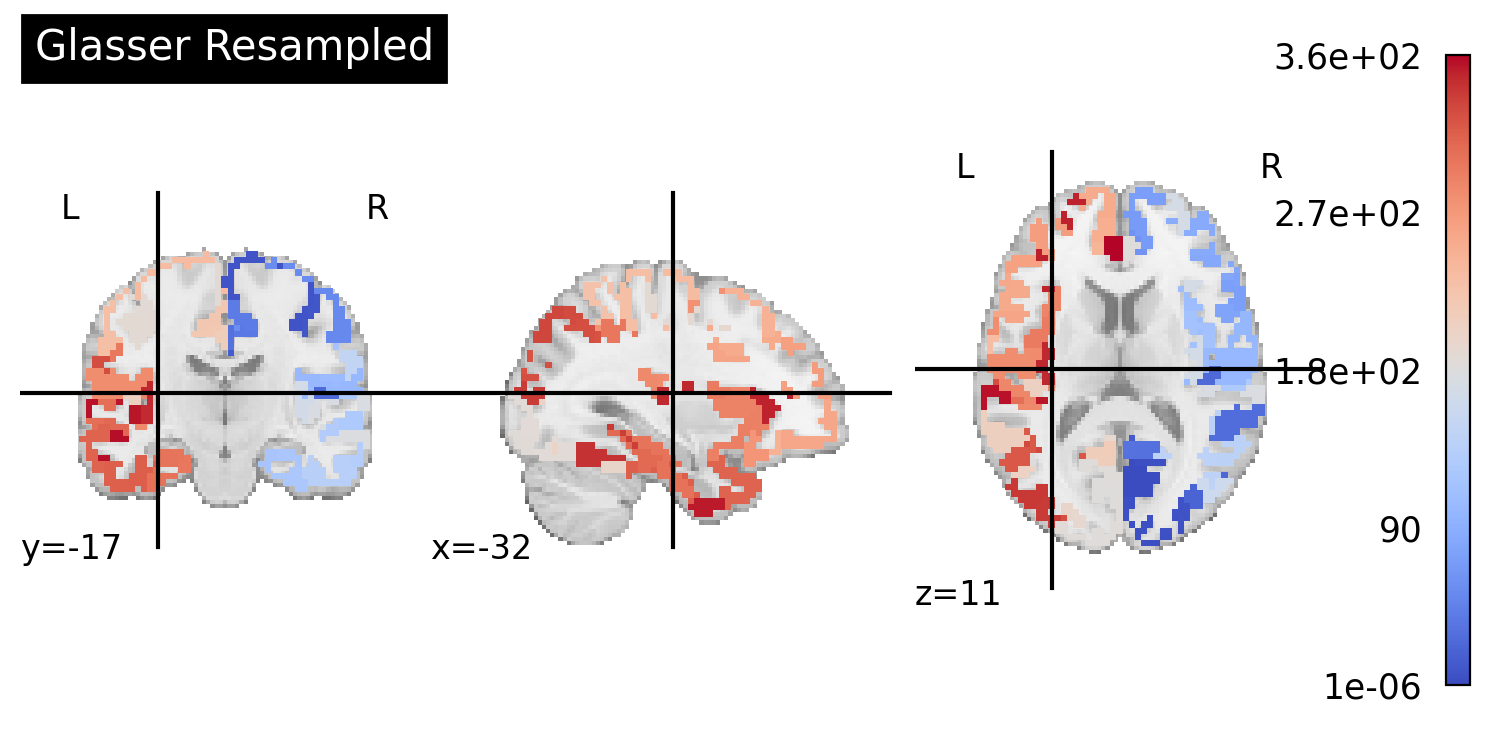

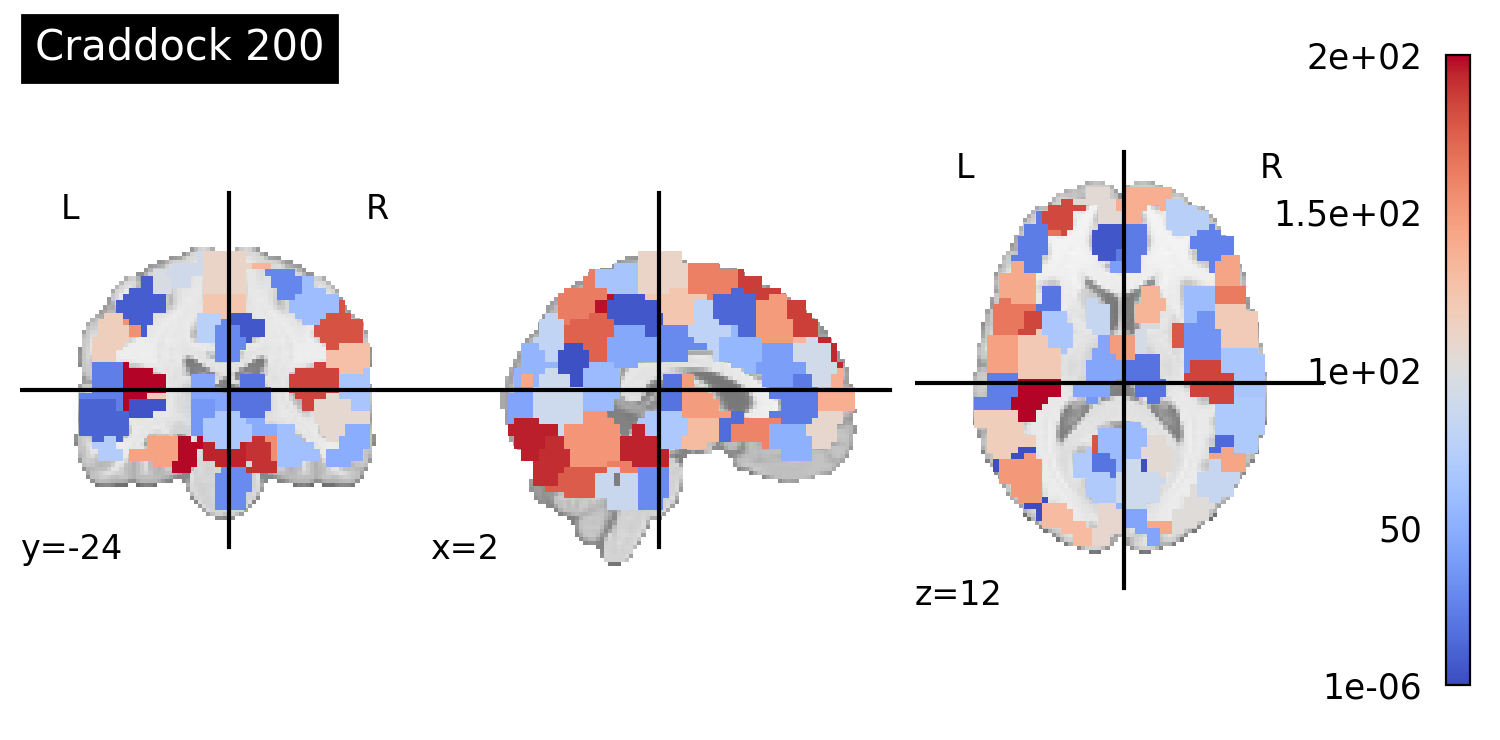

In [28]:
from nilearn.plotting import plot_stat_map

plot_stat_map(glasser_resampled, title="Glasser Resampled",
              display_mode='ortho', draw_cross=True, cmap='coolwarm')

plot_stat_map(craddock_img, title="Craddock 200",
              display_mode='ortho', draw_cross=True, cmap='coolwarm')

### **Task data**

In [29]:
#verifying path
# Path to HCP task data directory
hcp_task_path = "./DATA/hcp_task/subjects"

# Check if the directory exists
if os.path.exists(hcp_task_path):
    print("Task data directory found. Listing files...")
    print(os.listdir(hcp_task_path))
else:
    print("Task data directory NOT found. Check if the data is extracted properly.")


Task data directory found. Listing files...
['92', '._306', '._240', '._270', '68', '._217', '._258', '._286', '._287', '._143', '._77', '303', '337', '._51', '._253', '._151', '._205', '15', '._289', '242', '165', '._214', '._313', '._332', '._310', '157', '314', '271', '._156', '211', '._144', '._154', '8', '._59', '24', '34', '172', '304', '184', '._140', '4', '._42', '313', '161', '250', '._82', '159', '30', '17', '38', '59', '._22', '._36', '201', '._66', '197', '._302', '67', '294', '187', '191', '223', '283', '284', '._89', '212', '._60', '._115', '51', '._112', '._231', '._150', '330', '18', '._273', '293', '._284', '._245', '93', '._170', '2', '100', '._6', '._171', '5', '265', '._278', '117', '._153', '._141', '._327', '._85', '._293', '._219', '._309', '139', '._187', '._127', '135', '88', '270', '273', '._233', '._210', '._67', '57', '209', '113', '._199', '19', '._336', '._83', '._149', '297', '._137', '12', '._106', '._40', '31', '._257', '158', '58', '._30', '._12', '._2

In [30]:
#checking subject folder
subject_id = "92"
subject_task_path = os.path.join("./DATA/hcp_task/subjects", subject_id)

if os.path.exists(subject_task_path):
    print(f"Subject {subject_id} task data found. Listing files...")
    print(os.listdir(subject_task_path))
else:
    print(f"No task data found for subject {subject_id}. Check directory structure.")


Subject 92 task data found. Listing files...
['._timeseries', 'timeseries', '._.DS_Store', '.DS_Store', 'EVs', '._EVs']


In [31]:
timeseries_path = os.path.join("./DATA/hcp_task/subjects", "318", "timeseries")  # Replace 318 with another valid subject if needed

if os.path.exists(timeseries_path):
    print("Found timeseries folder. Available files:", os.listdir(timeseries_path))
else:
    print("No timeseries folder found for task data. Check data extraction.")


Found timeseries folder. Available files: ['bold11_Atlas_MSMAll_Glasser360Cortical.npy', 'bold16_Atlas_MSMAll_Glasser360Cortical.npy', 'bold18_Atlas_MSMAll_Glasser360Cortical.npy', 'bold9_Atlas_MSMAll_Glasser360Cortical.npy', 'bold10_Atlas_MSMAll_Glasser360Cortical.npy', 'bold8_Atlas_MSMAll_Glasser360Cortical.npy', 'bold6_Atlas_MSMAll_Glasser360Cortical.npy', 'bold7_Atlas_MSMAll_Glasser360Cortical.npy', 'bold12_Atlas_MSMAll_Glasser360Cortical.npy', 'bold17_Atlas_MSMAll_Glasser360Cortical.npy', 'bold14_Atlas_MSMAll_Glasser360Cortical.npy', 'bold13_Atlas_MSMAll_Glasser360Cortical.npy', 'bold5_Atlas_MSMAll_Glasser360Cortical.npy', 'bold15_Atlas_MSMAll_Glasser360Cortical.npy']


In [32]:
# List all bold files found
bold_files = os.listdir(timeseries_path)

# Check if any file corresponds to SOCIAL task
social_task_files = [file for file in bold_files if "bold" in file and any(x in file for x in ["15", "16"])] # Adjust these numbers if needed

if social_task_files:
    print(f"Found potential Social Cognition task files: {social_task_files}")
else:
    print("No specific task file identified. Need to check task-condition mapping.")


Found potential Social Cognition task files: ['bold16_Atlas_MSMAll_Glasser360Cortical.npy', 'bold15_Atlas_MSMAll_Glasser360Cortical.npy']


In [33]:
#loading task based FC data
# Define file paths
social_task_file1 = os.path.join(timeseries_path, "bold15_Atlas_MSMAll_Glasser360Cortical.npy")
social_task_file2 = os.path.join(timeseries_path, "bold16_Atlas_MSMAll_Glasser360Cortical.npy")

# Loading both runs
social_task_data1 = np.load(social_task_file1)
social_task_data2 = np.load(social_task_file2)

# Printing shape for verification
print(f"Loaded Social Cognition Task Data (Run 1): {social_task_data1.shape}")  # Expected: (360, Timepoints)
print(f"Loaded Social Cognition Task Data (Run 2): {social_task_data2.shape}")  # Expected: (360, Timepoints)


Loaded Social Cognition Task Data (Run 1): (360, 232)
Loaded Social Cognition Task Data (Run 2): (360, 232)


In [34]:
hcp_task_dir = "./DATA/hcp_task/subjects"

# List only valid numeric subject directories (ignoring system files)
subject_ids = sorted([s for s in os.listdir(hcp_task_dir) if s.isdigit()])

print(f"Found {len(subject_ids)} valid subjects.")

Found 339 valid subjects.


In [35]:
# Pick a sample subject from the filtered list
sample_subject = subject_ids[0]  # First valid subject
run1_path = os.path.join(hcp_task_dir, sample_subject, "timeseries", "bold15_Atlas_MSMAll_Glasser360Cortical.npy")
run2_path = os.path.join(hcp_task_dir, sample_subject, "timeseries", "bold16_Atlas_MSMAll_Glasser360Cortical.npy")

# Check if both task runs exist
if os.path.exists(run1_path) and os.path.exists(run2_path):
    print(f"Both runs exist for subject {sample_subject}")
    run1_timeseries = np.load(run1_path)
    run2_timeseries = np.load(run2_path)
    print(f"Run 1 Shape: {run1_timeseries.shape}, Run 2 Shape: {run2_timeseries.shape}")

else:
    print(f"Missing one or both runs for subject {sample_subject}. Check filenames and paths.")

Both runs exist for subject 0
Run 1 Shape: (360, 232), Run 2 Shape: (360, 232)


In [36]:
#RESAMPLE GLASSER VOLUMETRIC ATLAS TO MATCH CRADDOCK ATLAS
from nilearn.image import resample_to_img

# Define file paths
glasser_mni_path = "/content/drive/MyDrive/glasser360MNI.nii"  # The volumetric Glasser
craddock_mni_path = "/content/drive/MyDrive/CC200.nii"  # The Craddock atlas

# Load the images
glasser_mni = nib.load(glasser_mni_path)
craddock_mni = nib.load(craddock_mni_path)

# Resample Glasser to match Craddock resolution
glasser_resampled = resample_to_img(glasser_mni, craddock_mni, interpolation='nearest')

# Save the resampled file
resampled_glasser_path = "/content/drive/MyDrive/glasser_resampled_to_craddock.nii.gz"
nib.save(glasser_resampled, resampled_glasser_path)

print(f"Glasser volumetric atlas resampled and saved at {resampled_glasser_path}")

<ipython-input-36-92268adf4dd2>:13: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  glasser_resampled = resample_to_img(glasser_mni, craddock_mni, interpolation='nearest')
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


Glasser volumetric atlas resampled and saved at /content/drive/MyDrive/glasser_resampled_to_craddock.nii.gz


In [37]:
#VERIFY ALIGNMENT
# Load data
glasser_data = glasser_resampled.get_fdata()
craddock_data = nib.load(craddock_mni_path).get_fdata()

# Compare shapes
print(f"Glasser Resampled Shape: {glasser_data.shape}")
print(f"Craddock Shape: {craddock_data.shape}")

# Check voxel-wise overlap
overlap_voxels = np.sum((glasser_data > 0) & (craddock_data > 0))
print(f"Overlapping Voxels: {overlap_voxels}")

if overlap_voxels > 0:
    print("Glasser and Craddock are correctly aligned in MNI space")
else:
    print("No overlap found. Check resampling and alignment.")

Glasser Resampled Shape: (63, 75, 61)
Craddock Shape: (63, 75, 61)
Overlapping Voxels: 21517
Glasser and Craddock are correctly aligned in MNI space


In [38]:
#COMPUTING VOXEL WISE ROI MAPPING (Glasser → Craddock)
# Extract voxel data arrays
glasser_voxels = glasser_resampled.get_fdata().astype(int)
craddock_voxels = nib.load(craddock_mni_path).get_fdata().astype(int)

# Compute mapping
roi_mapping = {}
unique_craddock_rois = np.unique(craddock_voxels[craddock_voxels > 0])

for cr_roi in unique_craddock_rois:
    mask = (craddock_voxels == cr_roi)
    mapped_labels = np.unique(glasser_voxels[mask])
    mapped_labels = mapped_labels[mapped_labels > 0]  # Remove background
    roi_mapping[cr_roi] = mapped_labels.tolist()

# Save mapping
np.save("/content/drive/MyDrive/glasser_to_craddock_mapping.npy", roi_mapping)

print("ROI Mapping Completed!")

ROI Mapping Completed!


In [39]:
#TRANSFORM TIME SERIES DATA
SAVE_DIR = "/content/drive/MyDrive/Craddock_Social_Cognition"
os.makedirs(SAVE_DIR, exist_ok=True)  # Ensure directory exists

# Load the precomputed mapping
mapping_path = "/content/drive/MyDrive/glasser_to_craddock_mapping.npy"
glasser_to_craddock_mapping = np.load(mapping_path, allow_pickle=True).item()

# Path to the Glasser ROI-based time series
hcp_task_dir = "./DATA/hcp_task/subjects"
subject_ids = sorted([s for s in os.listdir(hcp_task_dir) if s.isdigit()])
print(f"Found {len(subject_ids)} subjects.")

for subject in subject_ids:
    run1_path = os.path.join(hcp_task_dir, subject, "timeseries", "bold15_Atlas_MSMAll_Glasser360Cortical.npy")
    run2_path = os.path.join(hcp_task_dir, subject, "timeseries", "bold16_Atlas_MSMAll_Glasser360Cortical.npy")

    if not os.path.exists(run1_path) or not os.path.exists(run2_path):
        print(f"Missing Social Cognition task data for subject {subject}. Skipping.")
        continue  # Skip this subject

    print(f"Processing subject {subject}...")

    # Load both runs and concatenate
    run1_timeseries = np.load(run1_path)
    run2_timeseries = np.load(run2_path)
    social_task_timeseries = np.concatenate([run1_timeseries, run2_timeseries], axis=1)

    print(f" {subject} Concatenated Time Series Shape: {social_task_timeseries.shape}")

    # Initialize Craddock time series
    n_timepoints = social_task_timeseries.shape[1]
    craddock_timeseries = np.zeros((200, n_timepoints), dtype=np.float32)

    # Apply Glasser → Craddock mapping
    for cr_roi in range(1, 201):
        mapped_glasser_rois = np.array(glasser_to_craddock_mapping.get(cr_roi, []), dtype=int)

        if mapped_glasser_rois.size > 0:
            valid_indices = mapped_glasser_rois - 1  # Convert to zero-based indexing
            craddock_timeseries[cr_roi - 1, :] = np.mean(social_task_timeseries[valid_indices, :], axis=0)

    # **Save transformed Craddock time series in Google Drive**
    output_path = os.path.join(SAVE_DIR, f"sub-{subject}_SOCIAL_Craddock200.npy")
    np.save(output_path, craddock_timeseries)
    print(f"Saved transformed Craddock data for subject {subject} at {output_path}")

print("All subjects processed for Social Cognition task and saved to Google Drive!")

Found 339 subjects.
Processing subject 0...
 0 Concatenated Time Series Shape: (360, 464)
Saved transformed Craddock data for subject 0 at /content/drive/MyDrive/Craddock_Social_Cognition/sub-0_SOCIAL_Craddock200.npy
Processing subject 1...
 1 Concatenated Time Series Shape: (360, 464)
Saved transformed Craddock data for subject 1 at /content/drive/MyDrive/Craddock_Social_Cognition/sub-1_SOCIAL_Craddock200.npy
Processing subject 10...
 10 Concatenated Time Series Shape: (360, 464)
Saved transformed Craddock data for subject 10 at /content/drive/MyDrive/Craddock_Social_Cognition/sub-10_SOCIAL_Craddock200.npy
Processing subject 100...
 100 Concatenated Time Series Shape: (360, 464)
Saved transformed Craddock data for subject 100 at /content/drive/MyDrive/Craddock_Social_Cognition/sub-100_SOCIAL_Craddock200.npy
Processing subject 101...
 101 Concatenated Time Series Shape: (360, 464)
Saved transformed Craddock data for subject 101 at /content/drive/MyDrive/Craddock_Social_Cognition/sub-10

In [40]:
# Verify transformation for subjects

# Define the path to the saved Craddock-transformed data
craddock_dir = "/content/drive/MyDrive/Craddock_Social_Cognition"

# List all transformed files
craddock_files = sorted([f for f in os.listdir(craddock_dir) if f.endswith("Craddock200.npy")])
print(f"Found {len(craddock_files)} transformed Craddock time series.")

# Select a sample subject to check
sample_subject_file = os.path.join(craddock_dir, craddock_files[0])
craddock_timeseries = np.load(sample_subject_file)

# Compute Mean Activation
mean_craddock = np.mean(craddock_timeseries)
nonzero_voxels = np.count_nonzero(craddock_timeseries)

print(f"Mean Activation (Craddock): {mean_craddock}")
print(f"Nonzero Craddock ROIs: {nonzero_voxels} / {craddock_timeseries.size}")

# Verify if data is nonzero
if mean_craddock == 0.0 or nonzero_voxels == 0:
    print("WARNING: Craddock data is all zeros! Check transformation steps.")
else:
    print("Craddock transformation is valid!")

Found 339 transformed Craddock time series.
Mean Activation (Craddock): 10043.591796875
Nonzero Craddock ROIs: 86304 / 92800
Craddock transformation is valid!


<Figure size 1000x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


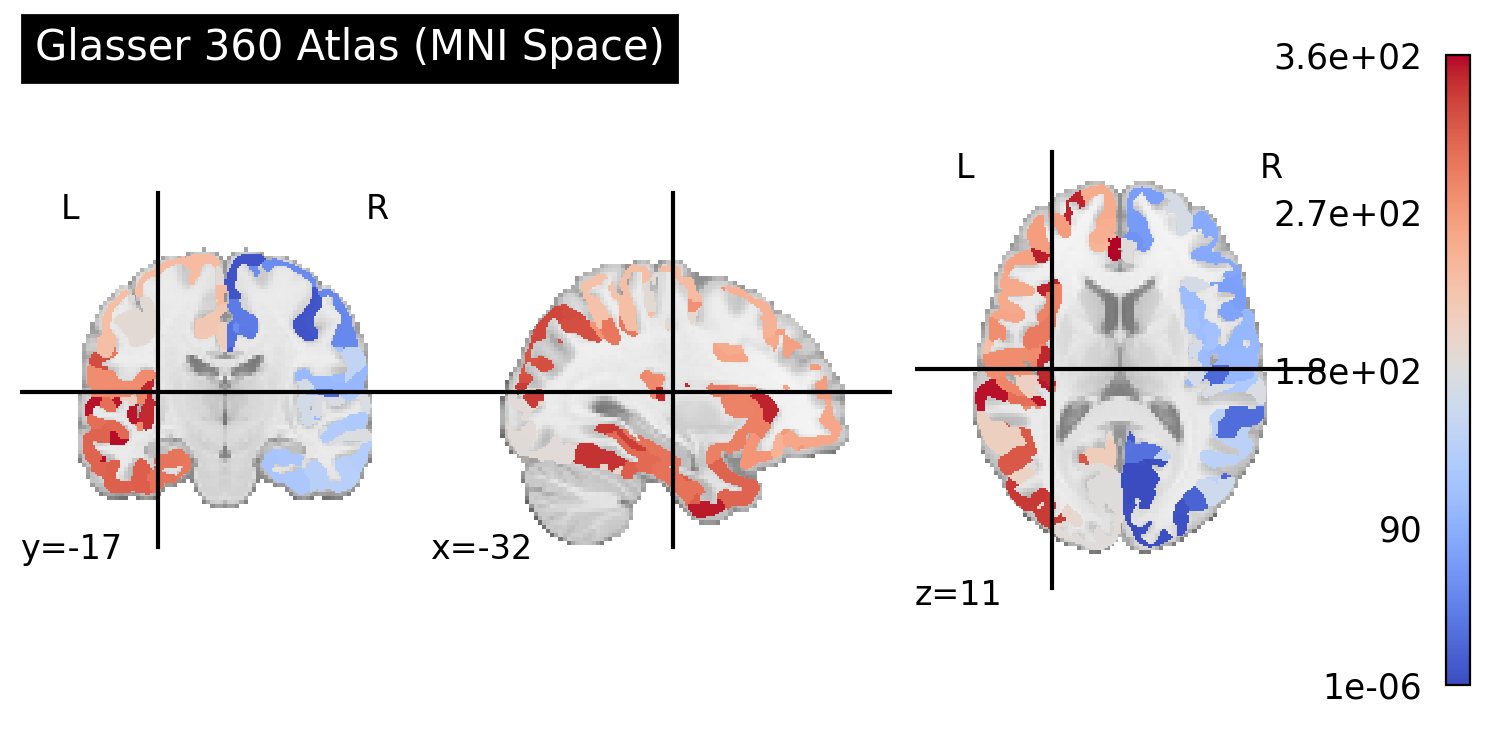

<Figure size 1000x500 with 0 Axes>

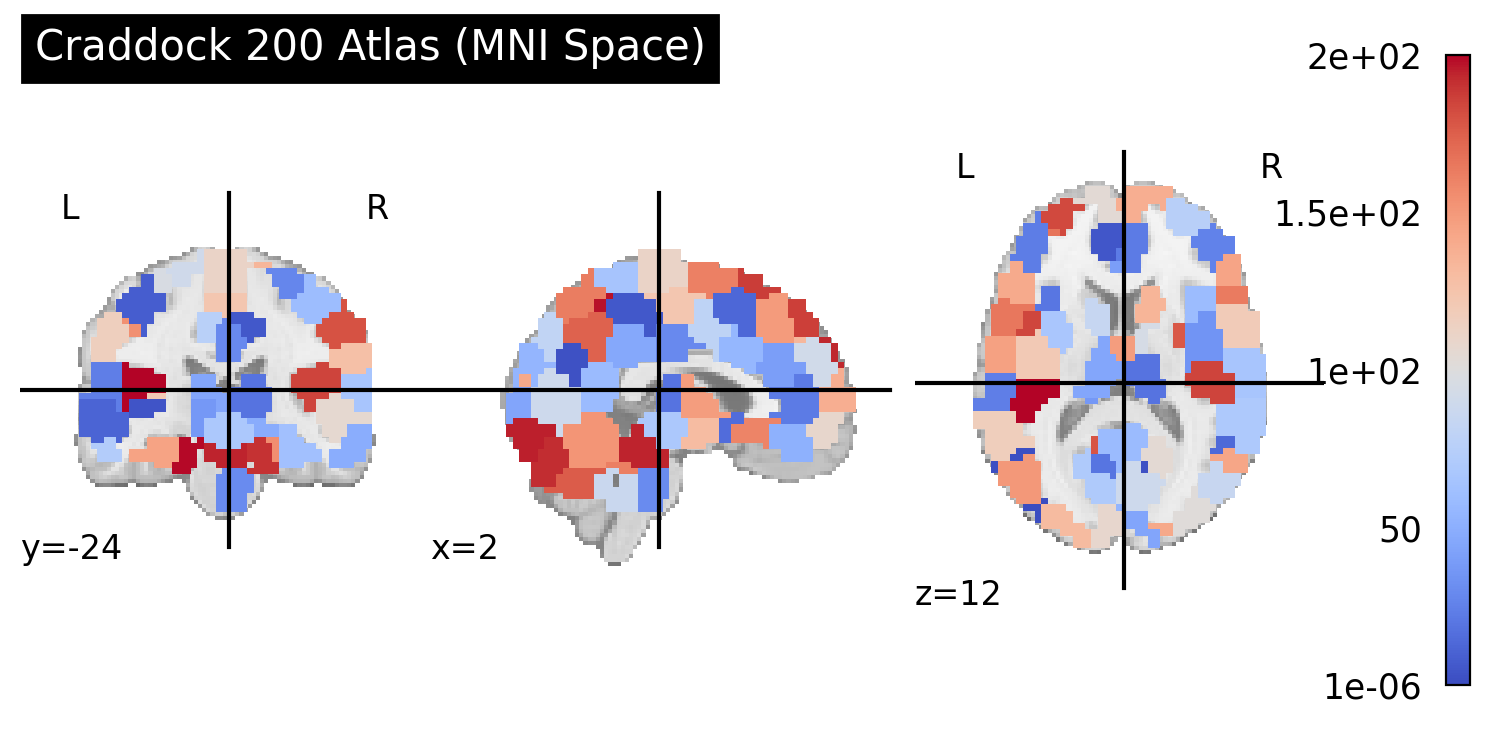

In [41]:
#VISUALISING ROI MAPPING
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map
import nibabel as nib

# Load resampled Craddock and Glasser atlases
glasser_img = nib.load("/content/drive/MyDrive/glasser360MNI.nii")
craddock_img = nib.load("/content/drive/MyDrive/craddock_resampled.nii")  # Ensure this was created correctly

# Plot Glasser Atlas
plt.figure(figsize=(10, 5))
plot_stat_map(glasser_img, title="Glasser 360 Atlas (MNI Space)",
              display_mode='ortho', draw_cross=True, cmap='coolwarm')

# Plot Craddock Atlas
plt.figure(figsize=(10, 5))
plot_stat_map(craddock_img, title="Craddock 200 Atlas (MNI Space)",
              display_mode='ortho', draw_cross=True, cmap='coolwarm')

plt.show()

### **Load Transformed Resting-State & Task Data**

In [44]:
# Paths to your saved Craddock-parcellated data
rest_data_dir = "/content/drive/MyDrive/resting_state_craddock"  # Resting-State
task_data_dir = "/content/drive/MyDrive/task_data_craddock"  # Social Cognition Task

# List all available subjects
rest_files = sorted([f for f in os.listdir(rest_data_dir) if f.endswith("_REST_Craddock200.npy")])
task_files = sorted([f for f in os.listdir(task_data_dir) if f.endswith("_SOCIAL_Craddock200.npy")])

assert len(rest_files) == len(task_files), "Mismatch in resting and task subjects!"

# Load all subjects' data into arrays
N_SUBJECTS = len(rest_files)
N_PARCELS = 200  # Craddock 200 ROIs

# Initialize storage arrays
restdata = []
task_activations = []

for rest_file, task_file in zip(rest_files, task_files):
    rest_path = os.path.join(rest_data_dir, rest_file)
    task_path = os.path.join(task_data_dir, task_file)

    rest_timeseries = np.load(rest_path)  # Shape: (200, timepoints)
    task_timeseries = np.load(task_path)  # Shape: (200, timepoints)

    # Append to list
    restdata.append(rest_timeseries)
    task_activations.append(task_timeseries.mean(axis=1))  # Average activation across time

# Convert to NumPy arrays
restdata = np.stack(restdata, axis=-1)  # Shape: (200, timepoints, N_SUBJECTS)
task_activations = np.stack(task_activations, axis=-1)  # Shape: (200, N_SUBJECTS)

print(f"Loaded Resting-State Data Shape: {restdata.shape}")  # (200, timepoints, subjects)
print(f"Loaded Task Activation Shape: {task_activations.shape}")  # (200, subjects)

Loaded Resting-State Data Shape: (200, 4800, 339)
Loaded Task Activation Shape: (200, 339)


**Compute Functional Connectivity (FC)**

In [45]:
# Number of nodes (ROIs)
numnodes = restdata.shape[0]

# Number of subjects
numsubjs = restdata.shape[2]

# Compute correlation-based FC matrix
restFC_corr = np.zeros((numnodes, numnodes, numsubjs))

for subj in range(numsubjs):
    restFC_corr[:, :, subj] = np.corrcoef(restdata[:, :, subj])  # Pearson correlation FC

print("Computed Correlation-Based Resting-State FC Matrix")
print(f"Shape: {restFC_corr.shape}")  # (200, 200, subjects)

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Computed Correlation-Based Resting-State FC Matrix
Shape: (200, 200, 339)


### Multiregression

In [46]:
from sklearn.linear_model import LinearRegression

# Number of nodes (ROIs)
numnodes = restdata.shape[0]

# Number of subjects
numsubjs = restdata.shape[2]

# Initialize Multi-Regression FC matrix
restFC_mreg = np.zeros((numnodes, numnodes, numsubjs))

# Compute regression-based FC for each subject
for subj in range(numsubjs):
    X = restdata[:, :, subj].T  # Shape: (timepoints, ROIs)
    fc_matrix = np.zeros((numnodes, numnodes))

    for target_roi in range(numnodes):
        y = X[:, target_roi]  # Target ROI signal
        X_predictors = np.delete(X, target_roi, axis=1)  # All other ROIs

        # Fit Multiple Regression Model
        model = LinearRegression()
        model.fit(X_predictors, y)

        # Store beta coefficients (functional connectivity)
        fc_matrix[target_roi, np.arange(numnodes) != target_roi] = model.coef_

    restFC_mreg[:, :, subj] = fc_matrix

print("Computed Multiple Regression-Based Resting-State FC Matrix")
print(f"Shape: {restFC_mreg.shape}")  # Expected: (200, 200, subjects)

Computed Multiple Regression-Based Resting-State FC Matrix
Shape: (200, 200, 339)


# Actflow Analysis

In [47]:
# Initialize array for predicted activations
predicted_activations_mreg = np.zeros_like(task_activations)  # (200, subjects)

# Compute AFM prediction for each subject
for subj in range(numsubjs):
    predicted_activations_mreg[:, subj] = restFC_mreg[:, :, subj] @ task_activations[:, subj]  # Matrix multiplication

print(f"Multi-Regression Activity Flow Mapping Predictions Computed! Shape: {predicted_activations_mreg.shape}")

Multi-Regression Activity Flow Mapping Predictions Computed! Shape: (200, 339)


In [48]:
from scipy.stats import pearsonr

# Compute correlation between actual & predicted task activations
subjectwise_correlations_mreg = [pearsonr(predicted_activations_mreg[:, subj], task_activations[:, subj])[0] for subj in range(numsubjs)]

# Print the average correlation
print(f"Mean Prediction Accuracy (Multi-Regression AFM): {np.mean(subjectwise_correlations_mreg):.3f}")

Mean Prediction Accuracy (Multi-Regression AFM): 0.943


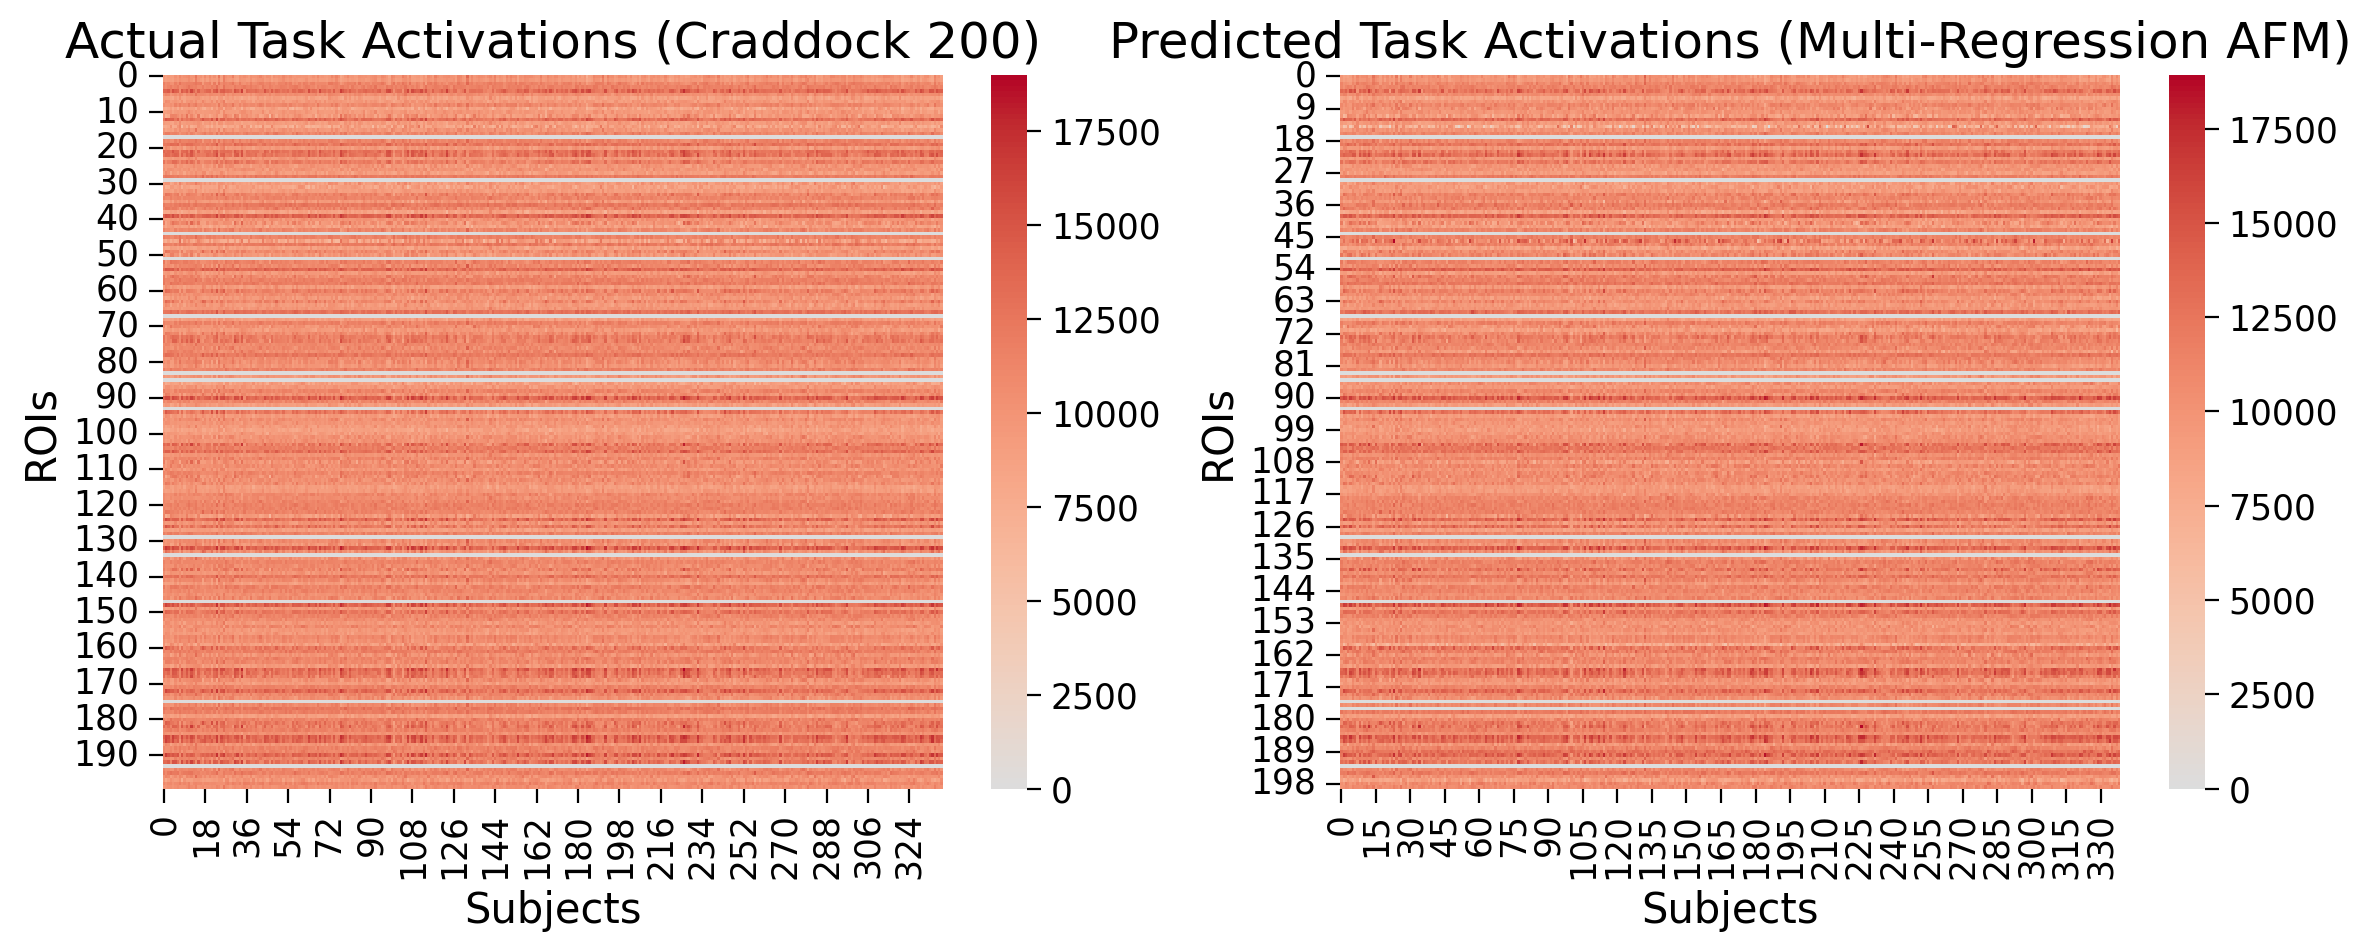

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Heatmap of Actual Activations
plt.subplot(1, 2, 1)
sns.heatmap(task_activations, cmap="coolwarm", center=0)
plt.title("Actual Task Activations (Craddock 200)")
plt.xlabel("Subjects")
plt.ylabel("ROIs")

# Heatmap of Predicted Activations (Multi-Regression)
plt.subplot(1, 2, 2)
sns.heatmap(predicted_activations_mreg, cmap="coolwarm", center=0)
plt.title("Predicted Task Activations (Multi-Regression AFM)")
plt.xlabel("Subjects")
plt.ylabel("ROIs")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


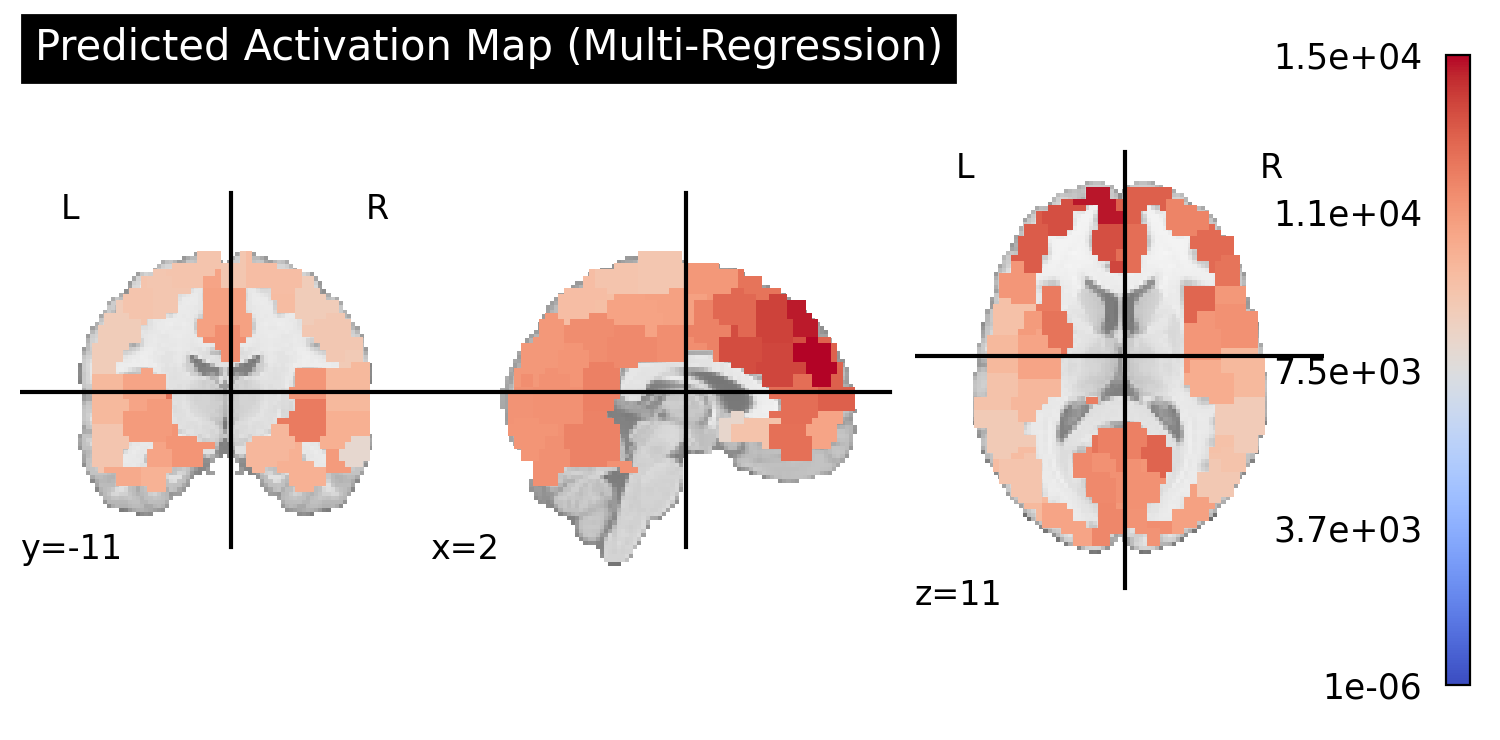

In [50]:
from nilearn import plotting

# Select a sample subject (e.g., subject 0)
sample_subject_idx = 0
sample_activation_mreg = predicted_activations_mreg[:, sample_subject_idx]

# Load Craddock ROI template for visualization
craddock_atlas = "/content/drive/MyDrive/CC200.nii"
craddock_img = nib.load(craddock_atlas)
craddock_data = craddock_img.get_fdata()

# Map activations to brain volume
brain_map = np.zeros_like(craddock_data)
for roi in range(1, 201):
    brain_map[craddock_data == roi] = sample_activation_mreg[roi - 1]  # Assign predicted activation

# Save and display the brain map
brain_img = nib.Nifti1Image(brain_map, craddock_img.affine)
plotting.plot_stat_map(brain_img, title="Predicted Activation Map (Multi-Regression)", display_mode="ortho", draw_cross=True, cmap="coolwarm")

# ABIDE Dataset

In [ ]:
# Main collect and download function
def collect_and_download(derivative, pipeline, strategy, out_dir, diagnosis):
    import os
    import urllib.request as request

    # Init variables
    mean_fd_thresh = 0.2
    s3_prefix = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative'
    s3_pheno_path = '/'.join([s3_prefix, 'Phenotypic_V1_0b_preprocessed1.csv'])

    derivative = derivative.lower()
    pipeline = pipeline.lower()
    strategy = strategy.lower()

    # Check derivative for extension
    if 'roi' in derivative:
        extension = '.1D'
    else:
        extension = '.nii.gz'

    if not os.path.exists(out_dir):
        print('Could not find {0}, creating now...'.format(out_dir))
        os.makedirs(out_dir)

    s3_pheno_file = request.urlopen(s3_pheno_path)
    pheno_list = s3_pheno_file.readlines()

    header = pheno_list[0].decode().split(',')
    try:
        site_idx = header.index('SITE_ID')
        file_idx = header.index('FILE_ID')
        age_idx = header.index('AGE_AT_SCAN')
        sex_idx = header.index('SEX')
        dx_idx = header.index('DX_GROUP')
        mean_fd_idx = header.index('func_mean_fd')
    except Exception as exc:
        err_msg = 'Unable to extract header information from the pheno file...'
        raise Exception(err_msg)

    s3_paths = []
    for pheno_row in pheno_list[1:]:
        cs_row = pheno_row.decode().split(',')

        try:
            row_file_id = cs_row[file_idx]
            row_site = cs_row[site_idx]
            row_age = float(cs_row[age_idx])
            row_sex = cs_row[sex_idx]
            row_dx = cs_row[dx_idx]
            row_mean_fd = float(cs_row[mean_fd_idx])
        except Exception as e:
            continue

        if row_file_id == 'no_filename':
            continue
        if row_mean_fd >= mean_fd_thresh:
            continue

        if (diagnosis == 'asd' and row_dx != '1') or (diagnosis == 'tdc' and row_dx != '2'):
            continue

        filename = row_file_id + '_' + derivative + extension
        s3_path = '/'.join([s3_prefix, 'Outputs', pipeline, strategy, derivative, filename])
        s3_paths.append(s3_path)

    total_num_files = len(s3_paths)
    for path_idx, s3_path in enumerate(s3_paths):
        rel_path = s3_path.lstrip(s3_prefix)
        download_file = os.path.join(out_dir, rel_path)
        download_dir = os.path.dirname(download_file)
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        try:
            if not os.path.exists(download_file):
                print('Retrieving: {0}'.format(download_file))
                request.urlretrieve(s3_path, download_file)
                print('{0:.3f}% percent complete'.format(100*(float(path_idx+1)/total_num_files)))
            else:
                print('File {0} already exists, skipping...'.format(download_file))
        except Exception as exc:
            print('There was a problem downloading {0}.\n Check input arguments and try again.'.format(s3_path))

    print('Done!')

# pipelines = ["ccs", "cpac", "dparsf", "niak"]
# strategies = ["filt_global", "filt_noglobal", "nofilt_global", "nofilt_noglobal"]
# derivatives = ["alff", "degree_binarize", "degree_weighted", "dual_regression", "eigenvector_binarize", "eigenvector_weighted", "falff", "func_mask", "func_mean", "func_preproc", "lfcd", "reho", "rois_aal", "rois_cc200", "rois_cc400", "rois_dosenbach160", "rois_ez", "rois_ho", "rois_tt", "vmhc"]
# extensions = ["1D", "nii.gz"]

# Variables to specify download settings (modify these values as needed)
desired_derivative = 'rois_cc200'  # Derivative of interest (e.g. 'reho')
desired_pipeline = 'cpac'     # Pipeline used to preprocess the data (e.g. 'cpac')
desired_strategy = 'filt_global'  # Noise-removal strategy used during preprocessing
download_data_dir = 'preprocessed_dataset'  # Path to local folder to download files to
desired_diagnosis = 'both'  # 'asd', 'tdc', or 'both' corresponding to the diagnosis of the participants for whom data should be downloaded

# Call the collect and download routine
collect_and_download(desired_derivative, desired_pipeline, desired_strategy, download_data_dir, desired_diagnosis)

Could not find preprocessed_dataset, creating now...
Retrieving: preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050004_rois_cc200.1D
0.113% percent complete
Retrieving: preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050005_rois_cc200.1D
0.226% percent complete
Retrieving: preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050006_rois_cc200.1D
0.339% percent complete
Retrieving: preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050007_rois_cc200.1D
0.452% percent complete
Retrieving: preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050008_rois_cc200.1D
0.566% percent complete
Retrieving: preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050009_rois_cc200.1D
0.679% percent complete
Retrieving: preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050010_rois_cc200.1D
0.792% percent complete
Retrieving: preprocessed_dataset/Outputs/cpac/filt_global/rois_cc200/Pitt_0050011_rois_cc200.1D
0.905% perc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
download_data_dir = '/content/drive/MyDrive/preprocessed_dataset'


In [ ]:
import os
import numpy as np
import pandas as pd

# Directory containing the .1D files (replace with your path)
data_dir = '/content/drive/MyDrive/preprocessed_dataset/'

import glob

# Define the path to the subject data files
data_files = glob.glob('/content/drive/MyDrive/preprocessed_dataset/dataset.zip/Outputs/cpac/filt_global/rois_cc200')  # Assuming 1D files for each subject


In [ ]:
import numpy as np

# Define the path to a sample subject file (assuming it's the same format for all subjects)
sample_file = '/content/drive/MyDrive/preprocessed_dataset/dataset.zip/Outputs/cpac/filt_global/rois_cc200/KKI_0050788_rois_cc200.1D'

# Load the data from the file
data = np.loadtxt(sample_file)

# Calculate the number of ROIs and number of time points
num_rois = data.shape[0]  # Number of rows = number of ROIs
num_time_points = data.shape[1]  # Number of columns = number of time points

print(f"Number of ROIs: {num_rois}")
print(f"Number of Time Points: {num_time_points}")


Number of ROIs: 152
Number of Time Points: 200


In [ ]:
import numpy as np
import glob

# List of files in the directory
data_files = glob.glob('/content/drive/MyDrive/preprocessed_dataset/dataset.zip/Outputs/cpac/filt_global/rois_cc200/*.1D')  # List of files

# Initialize variables to calculate the sum of ROIs and time points
total_rois = 0
total_time_points = 0
num_files = len(data_files)

# Iterate over all files to calculate the number of ROIs and time points
for file in data_files:
    data = np.loadtxt(file)
    num_rois, num_time_points = data.shape  # Get the dimensions of the data

    total_rois += num_rois
    total_time_points += num_time_points

# Calculate the average number of ROIs and time points
average_rois = total_rois / num_files
average_time_points = total_time_points / num_files

print(f"Average number of ROIs: {average_rois}")
print(f"Average number of time points: {average_time_points}")


Average number of ROIs: 192.2002262443439
Average number of time points: 200.0


In [ ]:
import numpy as np
from scipy.interpolate import interp1d
import glob

# Function to interpolate time series data
def interpolate_time_series(data, new_time_points, target_rois):
    # Check if data is 1D and reshape if needed
    if data.ndim == 1:
        data = data.reshape(1, -1)  # Reshape to (1, num_time_points)

    num_rois, num_time_points = data.shape  # Get dimensions after reshaping

    # If the number of ROIs is greater than the target, truncate. If less, pad with zeros
    if num_rois < target_rois:
        # Padding the data to match target ROIs
        padding = target_rois - num_rois
        data = np.pad(data, ((0, padding), (0, 0)), mode='constant')
    elif num_rois > target_rois:
        # Truncate the data to match target ROIs
        data = data[:target_rois, :]

    # Generate the original time points
    original_time_points = np.arange(num_time_points)

    # Ensure new_time_points is an integer array
    new_time_points = np.linspace(0, num_time_points - 1, new_time_points).astype(int)

    # Create an interpolator and apply it to each ROI
    interpolated_data = np.zeros((target_rois, new_time_points.size))  # Ensure the size matches the new time points
    for roi_idx in range(target_rois):
        f = interp1d(original_time_points, data[roi_idx, :], kind='linear', fill_value='extrapolate')
        interpolated_data[roi_idx, :] = f(new_time_points)

    return interpolated_data

# Define file pattern and read files
data_files = glob.glob('/content/drive/MyDrive/preprocessed_dataset/dataset.zip/Outputs/cpac/filt_global/rois_cc200/*.1D')  # List of files

# Initialize the matrix to hold the resting state data
num_rois = 192  # Set the desired number of ROIs
num_time_points = 200  # Set the desired number of time points
num_subjects = len(data_files)

# Initialize 3D matrix to hold the resting data (ROIs x time_points x subjects)
restdata = np.zeros((num_rois, num_time_points, num_subjects))

# Loop through each subject file and load the data into the restdata matrix
for i, file in enumerate(data_files):
    subj_data = np.loadtxt(file)  # Load the 1D file data

    # Handle mismatch in ROIs (resize if necessary)
    if subj_data.shape[0] != num_rois:
        subj_data = interpolate_time_series(subj_data, num_time_points, num_rois)

    # Handle mismatch in time points (resize if necessary)
    if subj_data.shape[1] != num_time_points:
        subj_data = interpolate_time_series(subj_data, num_time_points, num_rois)

    # Assign the processed data to the resting state matrix
    restdata[:, :, i] = subj_data.T  # Transpose if necessary to fit shape (ROIs, time_points)

# Check the final shape of the resting state data
print("Resting state data loaded with shape:", restdata.shape)


ValueError: could not broadcast input array from shape (200,192) into shape (192,200)

In [ ]:
import numpy as np
import glob

# Define the path to the subject data files
data_files = glob.glob('/path/to/preprocessed_data/interpolated_data/*.1D')  # Assuming 1D files for each subject

# Initialize the resting state data array
# Assuming each subject's file has time series for each ROI, and you know the number of ROIs and time points
num_rois = 192  # Number of ROIs (change as per your dataset)
num_time_points = 200  # Example, replace with actual time points
num_subjects = len(data_files)

# Initialize 3D matrix to hold the resting data
restdata = np.zeros((num_rois, num_time_points, num_subjects))

# Loop through each subject file and load the data into the restdata matrix
for i, file in enumerate(data_files):
    subj_data = np.loadtxt(file)  # Load the 1D file data
    restdata[:, :, i] = subj_data.T  # Transpose if necessary to fit shape (ROIs, time_points)

print("Resting state data loaded with shape:", restdata.shape)


Resting state data loaded with shape: (192, 200, 0)


In [ ]:

# Define the number of nodes and subjects
numnodes = restdata.shape[0]  # Number of ROIs
numsubjs = restdata.shape[2]  # Number of subjects

# Initialize FC matrix for storing results
restFC_mreg = np.zeros((numnodes, numnodes, numsubjs))

# Calculate multiple-regression FC for each subject
for scount in np.arange(numsubjs):
    restFC_mreg[:, :, scount] = actflow.connectivity_estimation.multregconn(restdata[:, :, scount])

print("Activity Flow Mapping completed.")


Activity Flow Mapping completed.


# Predictive Model from HCP
## Resting State to Social Cognition

In [ ]:
# Assuming 'restdata' is your input resting-state data for a subject (n_nodes x n_timepoints)
restFC_mreg = np.zeros((numnodes, numnodes, numsubjs))

for scount in np.arange(numsubjs):
    restFC_mreg[:,:,scount] = actflow.connectivity_estimation.multregconn(restdata[:,:,scount])

fcmat = np.mean(restFC_mreg[netorder,:,:][:, netorder,:], axis=2)


<ipython-input-76-dee6393bb6ff>:7: DeprecationWarning: Out of bound index found. This was previously ignored when the indexing result contained no elements. In the future the index error will be raised. This error occurs either due to an empty slice, or if an array has zero elements even before indexing.
(Use `warnings.simplefilter('error')` to turn this DeprecationWarning into an error and get more details on the invalid index.)
  fcmat = np.mean(restFC_mreg[netorder,:,:][:, netorder,:], axis=2)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [ ]:
task_data = activations_bycond[:, condNum]  # Extract condition data for social cognition task


In [ ]:
features = fcmat.flatten()  # Flatten the FC matrix as input features
target = task_data  # The target variable is the task-based social cognition activity


In [ ]:
# Suppose fcmat is of shape (num_subjects, n_nodes, n_nodes)
num_subjects = fcmat.shape[0]
n_nodes = fcmat.shape[1]

# Flatten the connectivity matrix for each subject (n_subjects, n_nodes^2)
X = fcmat.reshape(num_subjects, -1)

# Ensure the target vector y has the same number of subjects
y = task_data  # This should have shape (num_subjects,)


In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (360, 360)
y shape: (360, 100)


In [ ]:
# Example: Let's assume fcmat is the functional connectivity matrix of shape (num_subjects, n_nodes, n_nodes)
num_subjects = fcmat.shape[0]  # Number of subjects
n_nodes = fcmat.shape[1]  # Number of nodes

# Flatten the functional connectivity matrix for each subject into a 1D vector of size n_nodes^2
X = fcmat.reshape(num_subjects, -1)  # Shape (num_subjects, n_nodes^2)

# Check the shape of X
print("Shape of X (features):", X.shape)

# Ensure task_data has the correct shape
y = task_data  # Should be of shape (num_subjects,)
print("Shape of y (target):", y.shape)

# Proceed with training after ensuring shapes are consistent


Shape of X (features): (360, 360)
Shape of y (target): (360, 100)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Step 1: Clean or Impute the Data (Handle NaN values)
# Assuming X and y are already available

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)  # Handle missing values in X
y_imputed = imputer.fit_transform(y)  # Handle missing values in y

# Step 2: Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# Step 3: Define the Model
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # 128 neurons in the first hidden layer
model.add(Dense(64, activation='relu'))  # 64 neurons in the second hidden layer
model.add(Dense(32, activation='relu'))  # 32 neurons in the third hidden layer

# Add output layer with linear activation (since it's regression)
model.add(Dense(y_train.shape[1], activation='linear'))  # Number of outputs = 100

# Step 4: Compile the Model
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

# Step 5: Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Step 6: Evaluate the Model
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")

# Step 7: Make Predictions
y_pred = model.predict(X_val)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 531.8455 - mae: 17.0734 - val_loss: 630.6099 - val_mae: 18.7438
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 562.8188 - mae: 17.7608 - val_loss: 630.4644 - val_mae: 18.7414
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 556.0675 - mae: 17.5172 - val_loss: 630.3238 - val_mae: 18.7391
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 528.5842 - mae: 17.1187 - val_loss: 630.1830 - val_mae: 18.7368
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 578.1030 - mae: 17.9025 - val_loss: 630.0386 - val_mae: 18.7344
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 550.3336 - mae: 17.7021 - val_loss: 629.8945 - val_mae: 18.7320
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 591.6276 - mae: 18.2126 - val_loss: 629.7507 - val_mae: 18.7296
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 545.3682 - mae: 17.3610 - val_loss: 629.6077 - val_mae: 18.7273
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout

model = tf.keras.Sequential([
    Dense(512, activation='relu', input_shape=(360,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(100)
])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)  # You can experiment with different learning rates

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
from tensorflow.keras.regularizers import l2

model = tf.keras.Sequential([
    Dense(512, activation='relu', kernel_regularizer=l2(0.01), input_shape=(360,)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(100)
])


In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# Standardize the input data
scaler = StandardScaler()
X_clean = scaler.fit_transform(X_clean)

# Define the model
model = Sequential([
    Dense(512, activation='relu', input_shape=(360,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(100)
])

# Compile the model with Adam optimizer and Mean Squared Error loss
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Implement early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])


ValueError: Found array with 0 feature(s) (shape=(360, 0)) while a minimum of 1 is required by StandardScaler.

In [ ]:
# Example: Check columns with NaNs
print(np.isnan(X).any(axis=0))  # Check which columns have NaNs


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

# Archived Code (not necessary/doesn't work)

In [ ]:
#USING ACTFLOW MAPPING EXAMPLE CODE
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set task condition number for Social Mental Task
condNum = 22

# RestFC Predicted Activations
inputdata = np.mean(actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'], axis=2)[:, condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))

# Flip hemispheres (CAB-NP is left-to-right, wbplot uses right-to-left)
inputdata_flipped = np.zeros(np.shape(inputdata))
inputdata_flipped[0:180] = inputdata[180:360]
inputdata_flipped[180:360] = inputdata[0:180]

# Set colormap based on data range
colormap = 'Reds' if min(inputdata) >= 0 else 'seismic'

# Save predicted activations to file
file_out = "predicted_social_mental.png"
pscalar(
    file_out=file_out,
    pscalars=inputdata_flipped,
    cmap=colormap,
    transparent=True
)

# Display predicted activations
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Multreg restFC actflow predictions (Social Mental Task)')
plt.imshow(img)

# ----------------------------- #
# Actual Activations
inputdata = np.mean(activations_bycond, axis=2)[:, condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))

# Flip hemispheres again
inputdata_flipped = np.zeros(np.shape(inputdata))
inputdata_flipped[0:180] = inputdata[180:360]
inputdata_flipped[180:360] = inputdata[0:180]

# Set colormap again
colormap = 'Reds' if min(inputdata) >= 0 else 'seismic'

# Save actual activations to file
file_out = "actual_social_mental.png"
pscalar(
    file_out=file_out,
    pscalars=inputdata_flipped,
    cmap=colormap,
    transparent=True
)

# Display actual activations
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Actual Activations (Social Mental Task)')
plt.imshow(img)

plt.show()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Min value:  -15.468213175516714
Max value:  33.718228513607485


FileNotFoundError: [Errno 2] No such file or directory: 'predicted_social_mental.png'

**Scaling could improve the data? May not be necessary:**

- Method 1:subtract alpha and divide by scaling factor
- Method 2: add alpha and multiply scaling factor



In [ ]:
#SCALING METHOD 1
# Compute mean predicted and actual activations
predicted_mean = np.mean(actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'], axis=2)
actual_mean = np.mean(activations_bycond, axis=2)

# Compute per-region correction factor (blend ratio & offset)
scaling_factors = np.mean(predicted_mean / actual_mean, axis=1, keepdims=True)
offset_correction = np.mean(predicted_mean - actual_mean, axis=1, keepdims=True)

# Blend both scaling and offset correction (weight to prevent overcorrection)
alpha = 0.5  # Adjust alpha between 0 and 1 to tune correction strength
adjusted_predicted_mean = (predicted_mean - alpha * offset_correction) / (scaling_factors ** alpha)


<ipython-input-121-2c58717ce6ed>:12: RuntimeWarning: invalid value encountered in sqrt
  adjusted_predicted_mean = (predicted_mean - alpha * offset_correction) / (scaling_factors ** alpha)


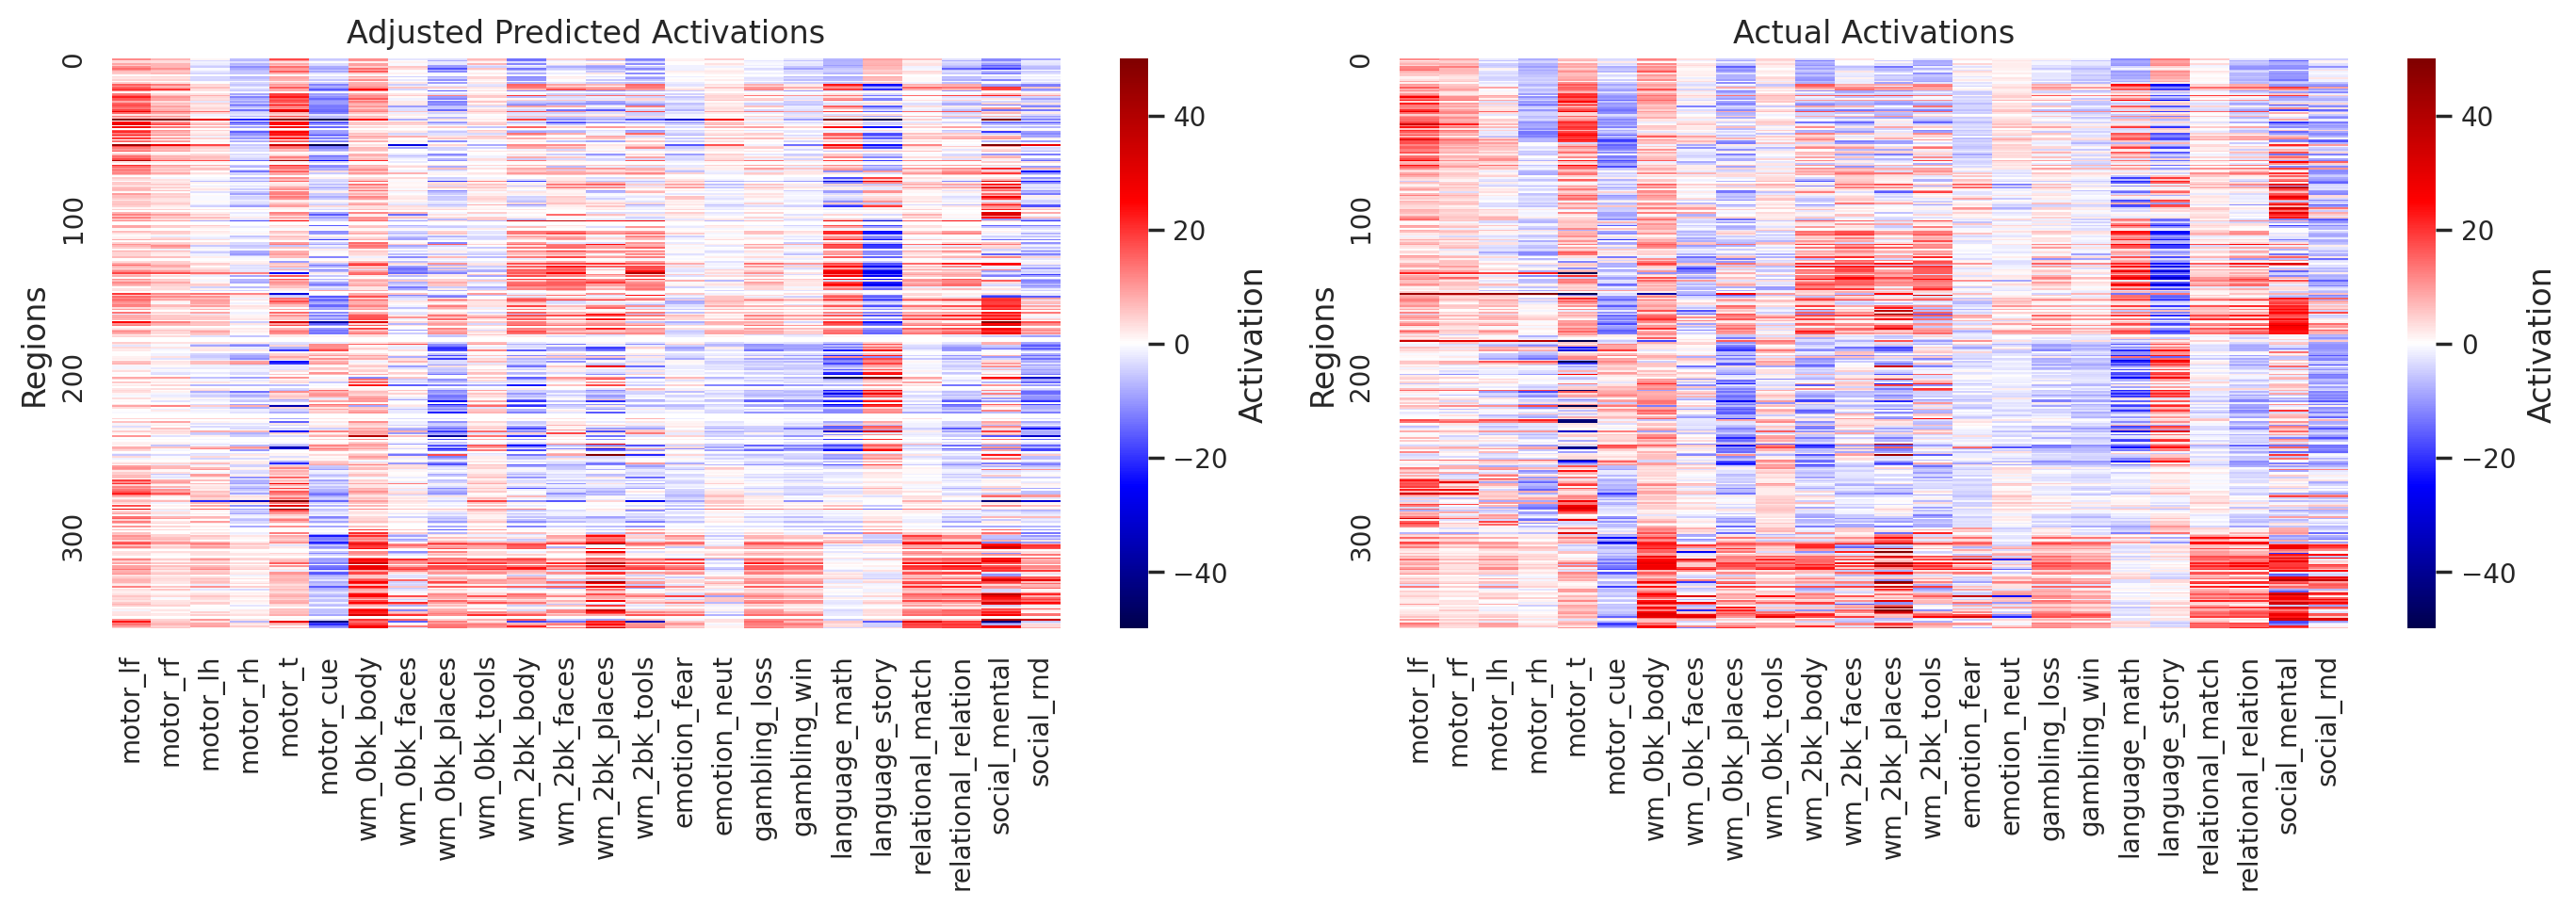

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot adjusted predicted activations
sns.heatmap(adjusted_predicted_mean[netorder, :], center=0, cmap='seismic',
            cbar=True, cbar_kws={'label': 'Activation'}, yticklabels=100,
            xticklabels=taskConditions, ax=axes[0],
            vmin=-50, vmax=50)  # Set fixed color scale
axes[0].set_title('Adjusted Predicted Activations')
axes[0].set_ylabel('Regions')

# Plot actual activations
sns.heatmap(np.mean(activations_bycond, axis=2)[netorder, :], center=0, cmap='seismic',
            cbar=True, cbar_kws={'label': 'Activation'}, yticklabels=100,
            xticklabels=taskConditions, ax=axes[1],
            vmin=-50, vmax=50)  # Set fixed color scale
axes[1].set_title('Actual Activations')
axes[1].set_ylabel('Regions')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
#SCALING METHOD 2 (seems to work better)
# Compute mean predicted and actual activations
predicted_mean = np.mean(actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'], axis=2)
actual_mean = np.mean(activations_bycond, axis=2)

# Compute per-region correction factor
scaling_factors = np.mean(predicted_mean / actual_mean, axis=1, keepdims=True)

# Compute per-region offset correction
offset_correction = np.mean(actual_mean - predicted_mean, axis=1, keepdims=True)

# Fine-tune the correction by introducing a **gentle boost**
alpha = 1  # Keeps it small to avoid overcorrection
adjusted_predicted_mean = (predicted_mean + alpha * offset_correction) * (scaling_factors ** (1 - alpha))


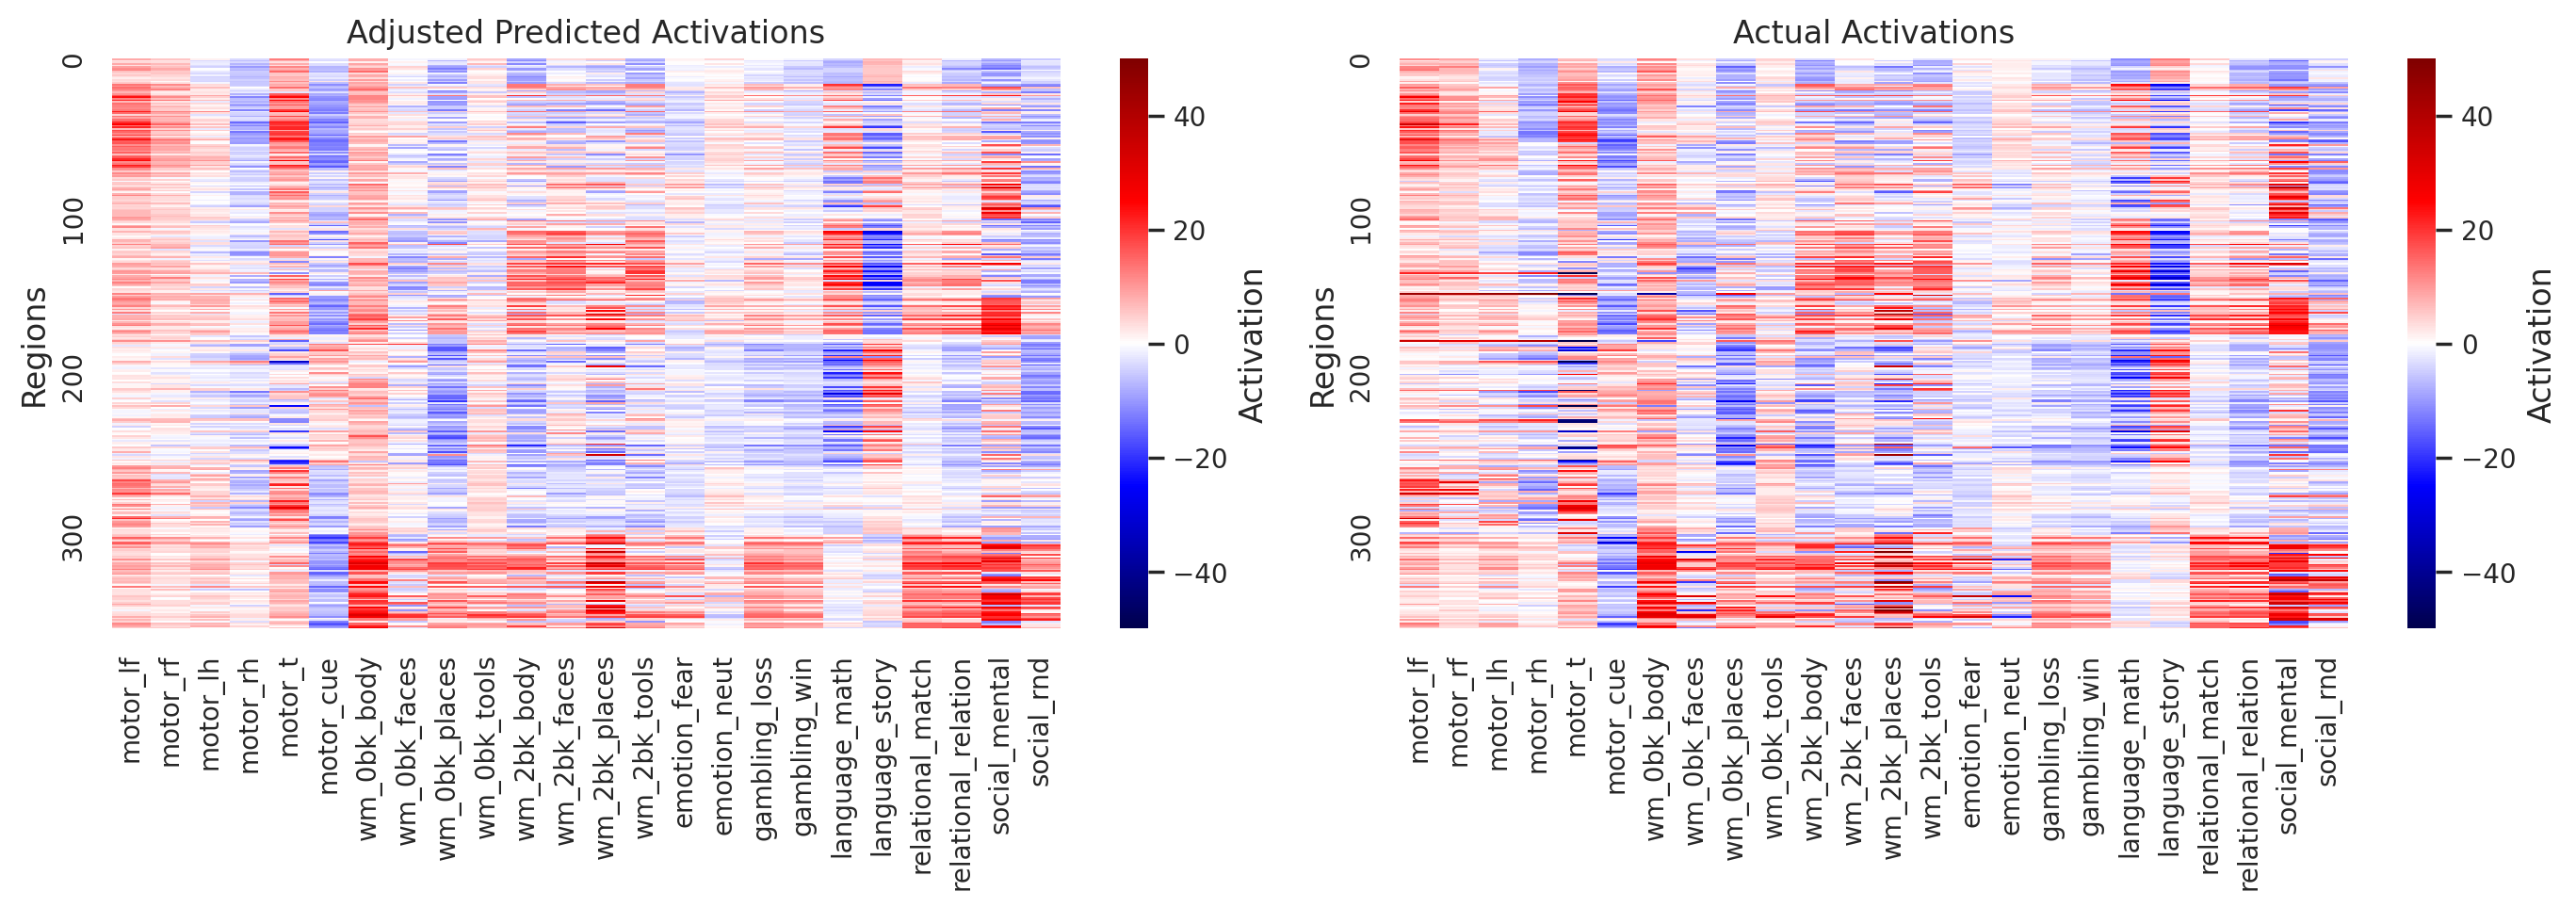

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot adjusted predicted activations
sns.heatmap(adjusted_predicted_mean[netorder, :], center=0, cmap='seismic',
            cbar=True, cbar_kws={'label': 'Activation'}, yticklabels=100,
            xticklabels=taskConditions, ax=axes[0],
            vmin=-50, vmax=50)  # Set fixed color scale
axes[0].set_title('Adjusted Predicted Activations')
axes[0].set_ylabel('Regions')

# Plot actual activations
sns.heatmap(np.mean(activations_bycond, axis=2)[netorder, :], center=0, cmap='seismic',
            cbar=True, cbar_kws={'label': 'Activation'}, yticklabels=100,
            xticklabels=taskConditions, ax=axes[1],
            vmin=-50, vmax=50)  # Set fixed color scale
axes[1].set_title('Actual Activations')
axes[1].set_ylabel('Regions')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
#Plotting brain surface images in-line, FC-based predictions

condNum=22 #condition 9 = relational reasoning

#RestFC predicted
inputdata=np.mean(actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'],axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Multreg restFC actflow predictions (relational reasoning)')
plt.imshow(img)

#Actual activity
inputdata=np.mean(activations_bycond,axis=2)[:,condNum]
print('Min value: ', np.min(inputdata))
print('Max value: ', np.max(inputdata))
#flip hemispheres, since CAB-NP is ordered left-to-right, while wbplot uses right-to-left
inputdata_flipped=np.zeros(np.shape(inputdata))
inputdata_flipped[0:180]=inputdata[180:360]
inputdata_flipped[180:360]=inputdata[0:180]
file_out="out.png"
#Set to all reds if no negative values
if min(inputdata) >= 0:
    colormap='Reds'
else:
    colormap='seismic'
pscalar(
        file_out=file_out,
        pscalars=inputdata_flipped,
        cmap=colormap,
        transparent=True)
img = mpimg.imread(file_out)
plt.figure()
plt.axis('off')
plt.title('Actual activations (relational reasoning)')
plt.imshow(img)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Min value:  -15.468213175516714
Max value:  33.718228513607485


FileNotFoundError: [Errno 2] No such file or directory: 'out.png'

In [ ]:
from sklearn.linear_model import Ridge
restFC__mrfc=np.zeros((N_PARCELS, N_PARCELS, N_SUBJECTS))

for subj_idx, subject in enumerate(range(N_SUBJECTS)):
  X=restdata[:,:,subj_idx].T #timepoints & regions
  restFC=np.zeros((N_PARCELS, N_PARCELS))

  for region in range(N_PARCELS):
    y= X[:, region] #target region's time series
    X_other=np.delete(X, region, axis=1) #remove target from predictors

    model=Ridge(alpha=1.0) #regularised multiregression
    model.fit(X_other, y)
    restFC[region, np.arange(N_PARCELS) != region] = model.coef_

  restFC__mrfc[:,:,subj_idx]=restFC #storing subject level MRFC

  print("==Activity flow mapping using correlation based FC==")
  actflowOutput_restFCCorr_bycond= actflow.actflowcomp.actflowtest(activations_bycond, restFC_corr)

  print("==Activity flow mapping using multi-regression FC==")
  actflowOutput_restFCCorr_bycond= actflow.actflowcomp.actflowtest(activations_bycond, restFC__mrfc)

==Activity flow mapping using correlation based FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 100 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.48, t-value vs. 0: 42.51, p-value vs. 0: 2.150275303421664e-65
 
Mean % variance explained (R^2 score, coeff. of determination) = -2398.02
 
Mean MAE (mean absolute error) = 751.73
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-learn.org/stable/modules/generate

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


==Activity flow mapping using correlation based FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 100 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.48, t-value vs. 0: 42.51, p-value vs. 0: 2.150275303421664e-65
 
Mean % variance explained (R^2 score, coeff. of determination) = -2398.02
 
Mean MAE (mean absolute error) = 751.73
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-learn.org/stable/modules/generate

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


==Activity flow mapping using correlation based FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 100 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.48, t-value vs. 0: 42.51, p-value vs. 0: 2.150275303421664e-65
 
Mean % variance explained (R^2 score, coeff. of determination) = -2398.02
 
Mean MAE (mean absolute error) = 751.73
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-learn.org/stable/modules/generate

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


==Activity flow mapping using correlation based FC==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 100 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.48, t-value vs. 0: 42.51, p-value vs. 0: 2.150275303421664e-65
 
Mean % variance explained (R^2 score, coeff. of determination) = -2398.02
 
Mean MAE (mean absolute error) = 751.73
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-learn.org/stable/modules/generate

KeyboardInterrupt: 

In [ ]:
#comparing Pearson FC and Multiregression FC
corr_FC_mean=np.mean(restFC_corr, axis=2)
mrfc_FC_mean= np.mean(restFC__mrfc, axis=2)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(corr_FC_mean, cmaps= "coolwarm", centre=0)
plt.title("Pearson FC")
plt.subplot(1,2,2)
sns.heatmap(mrfc_FC_mean, cmaps= "coolwarm", centre=0)
plt.title("Multiregression FC")

# Archive (from NMA)

# Resting-state analyses

Load a single run of resting-state data:

In [ ]:
help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, dir, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      dir (str) : data directory
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [ ]:
timeseries = load_timeseries(subject=0,
                             name="rest",
                             dir=os.path.join(HCP_DIR, "hcp_rest"),
                             runs=1)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 1200)


Load a concatenated resting-state timeseries (using all runs' data) for each subject:

In [ ]:
timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, name="rest",
                              dir=os.path.join(HCP_DIR, "hcp_rest"))
  timeseries_rest.append(ts_concat)

## Run a simple correlation-based "functional connectivity" analysis

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and plot the group average:

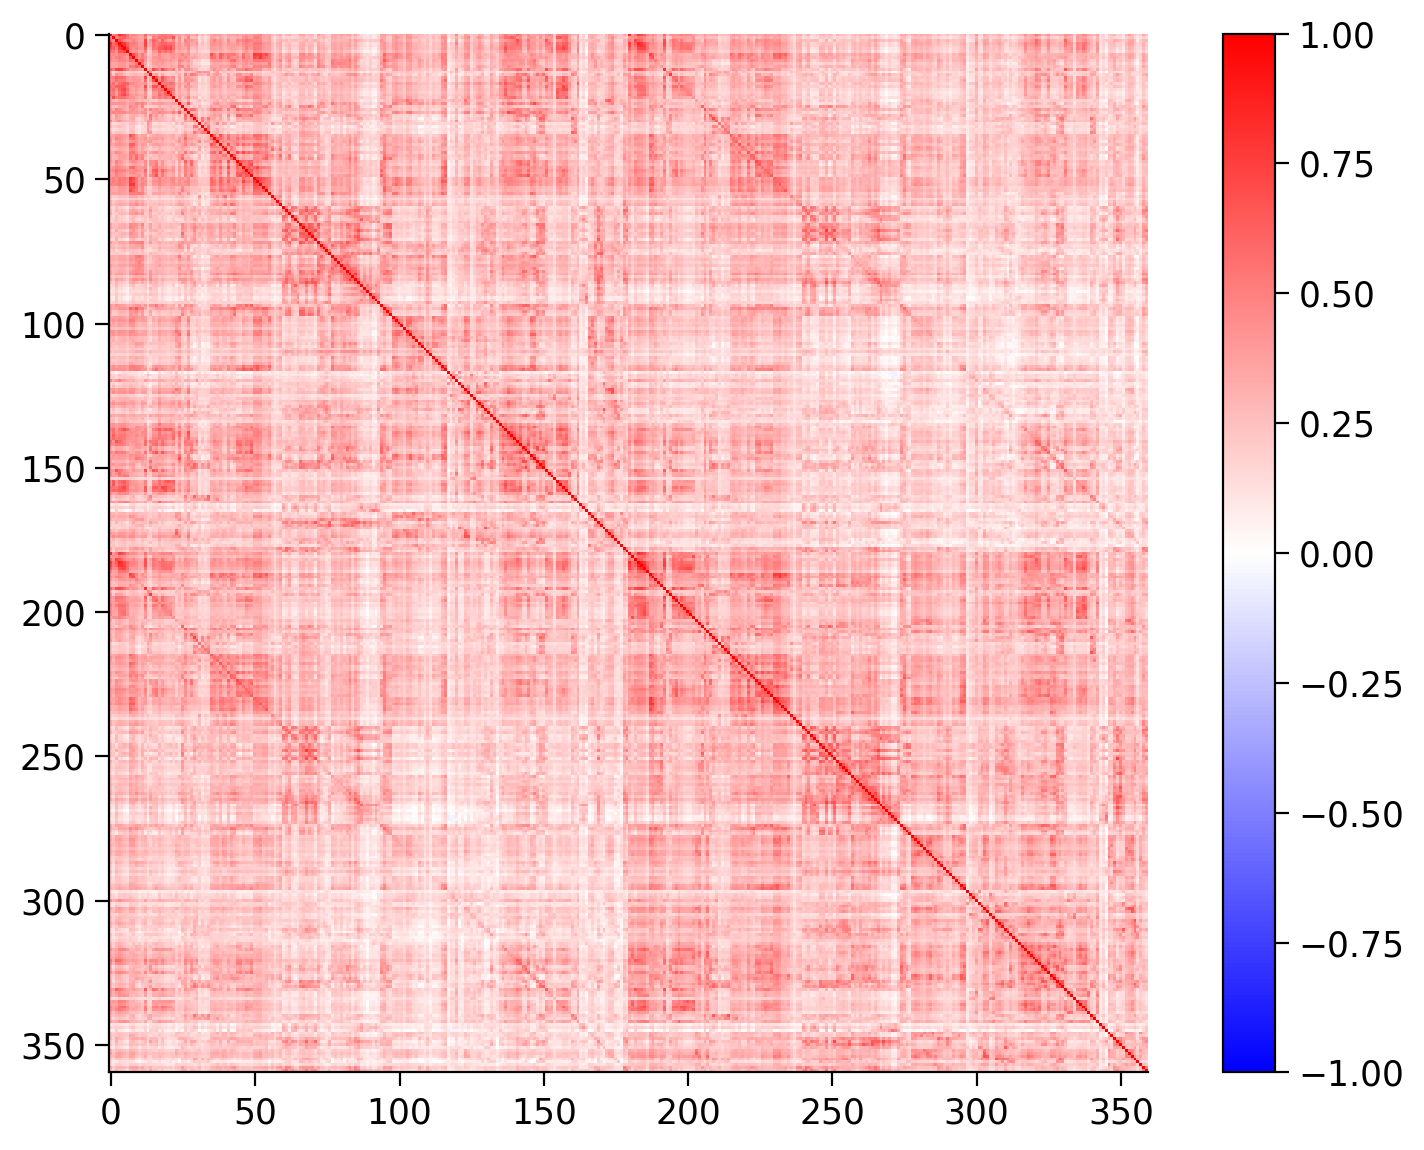

In [ ]:
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef(ts)

group_fc = fc.mean(axis=0)

plt.figure()
plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

Plot the profile of FC values between a particular "seed" parcel and every parcel in the dataset, separated by hemisphere:

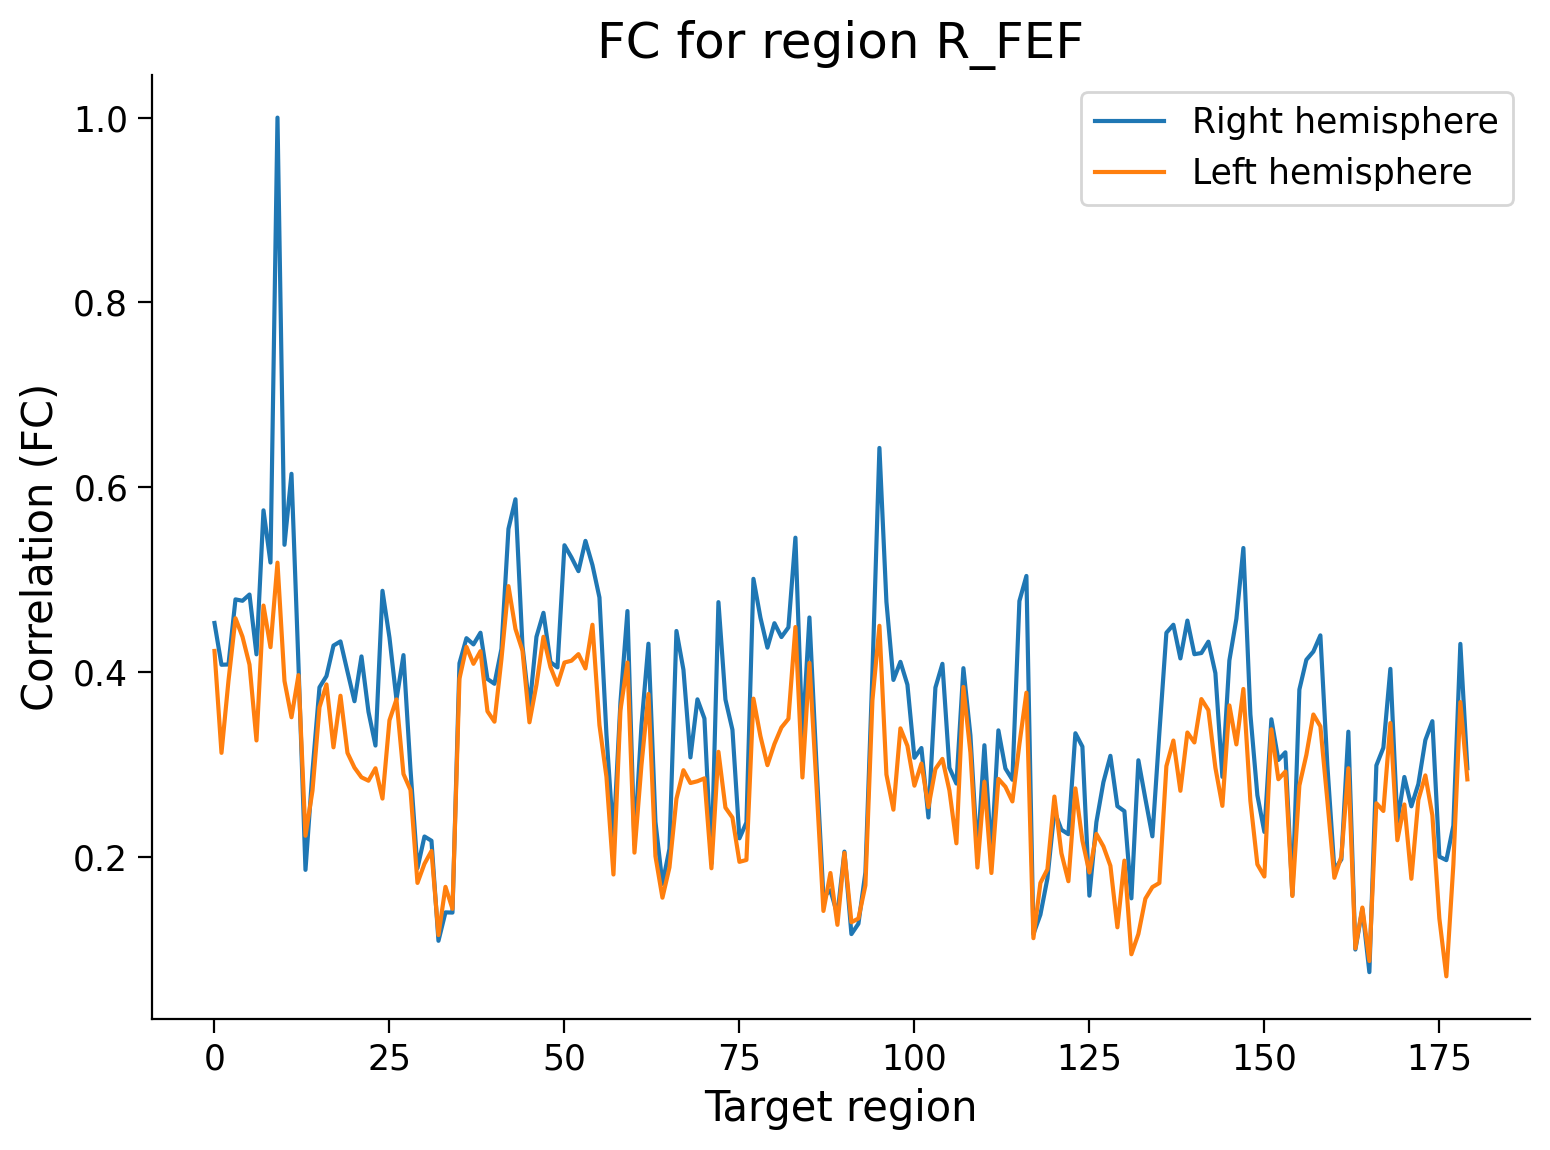

In [ ]:
seed_roi = "R_FEF"  # name of seed parcel
ind = region_info["name"].index(seed_roi)

hemi_fc = np.split(group_fc, 2)

# Plot the FC profile across the right and left hemisphere target regions
plt.figure()
for i, hemi_fc in enumerate(hemi_fc):
  plt.plot(hemi_fc[:, ind], label=f"{HEMIS[i]} hemisphere")
plt.title(f"FC for region {seed_roi}")
plt.xlabel("Target region")
plt.ylabel("Correlation (FC)")
plt.legend()
plt.show()

Threshold the correlation matrix to produce a connectome, and plot it:

In [ ]:
plotting.view_connectome(group_fc, atlas["coords"], edge_threshold="99%")

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools,
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

## Load individual runs for a given task

Load each subject's data for a specific task, separately for each run:

In [ ]:
timeseries_task = []
for subject in subjects:
  timeseries_task.append(load_timeseries(subject, "motor",
                                         dir=os.path.join(HCP_DIR, "hcp_task"),
                                         concat=False))

## Run a simple subtraction analysis

In [ ]:
help(load_evs)

Help on function load_evs in module __main__:

load_evs(subject, name, condition, dir)
    Load EV (explanatory variable) data for one task condition.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of task
      condition (str) : Name of condition
      dir (str) : data directory
    
    Returns
      evs (list of dicts): A dictionary with the onset, duration, and amplitude
        of the condition for each run.



In [ ]:
help(selective_average)

Help on function selective_average in module __main__:

selective_average(timeseries_data, ev, skip=0)
    Take the temporal mean across frames for a given condition.
    
    Args:
      timeseries_data (array or list of arrays): n_parcel x n_tp arrays
      ev (dict or list of dicts): Condition timing information
      skip (int) : Ignore this many frames at the start of each trial, to account
        for hemodynamic lag
    
    Returns:
      avg_data (1D array): Data averagted across selected image frames based
      on condition timing



In [ ]:
task = "motor"
conditions = ["lf", "rf"]  # Run a substraction analysis between two conditions

contrast = []
for subject in subjects:

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond, dir=os.path.join(HCP_DIR, "hcp_task")) for cond in conditions]
  avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]

  # Store the region-wise difference
  contrast.append(avgs[0] - avgs[1])

group_contrast = np.mean(contrast, axis=0)

Plot group-averaged contrast value across regions:

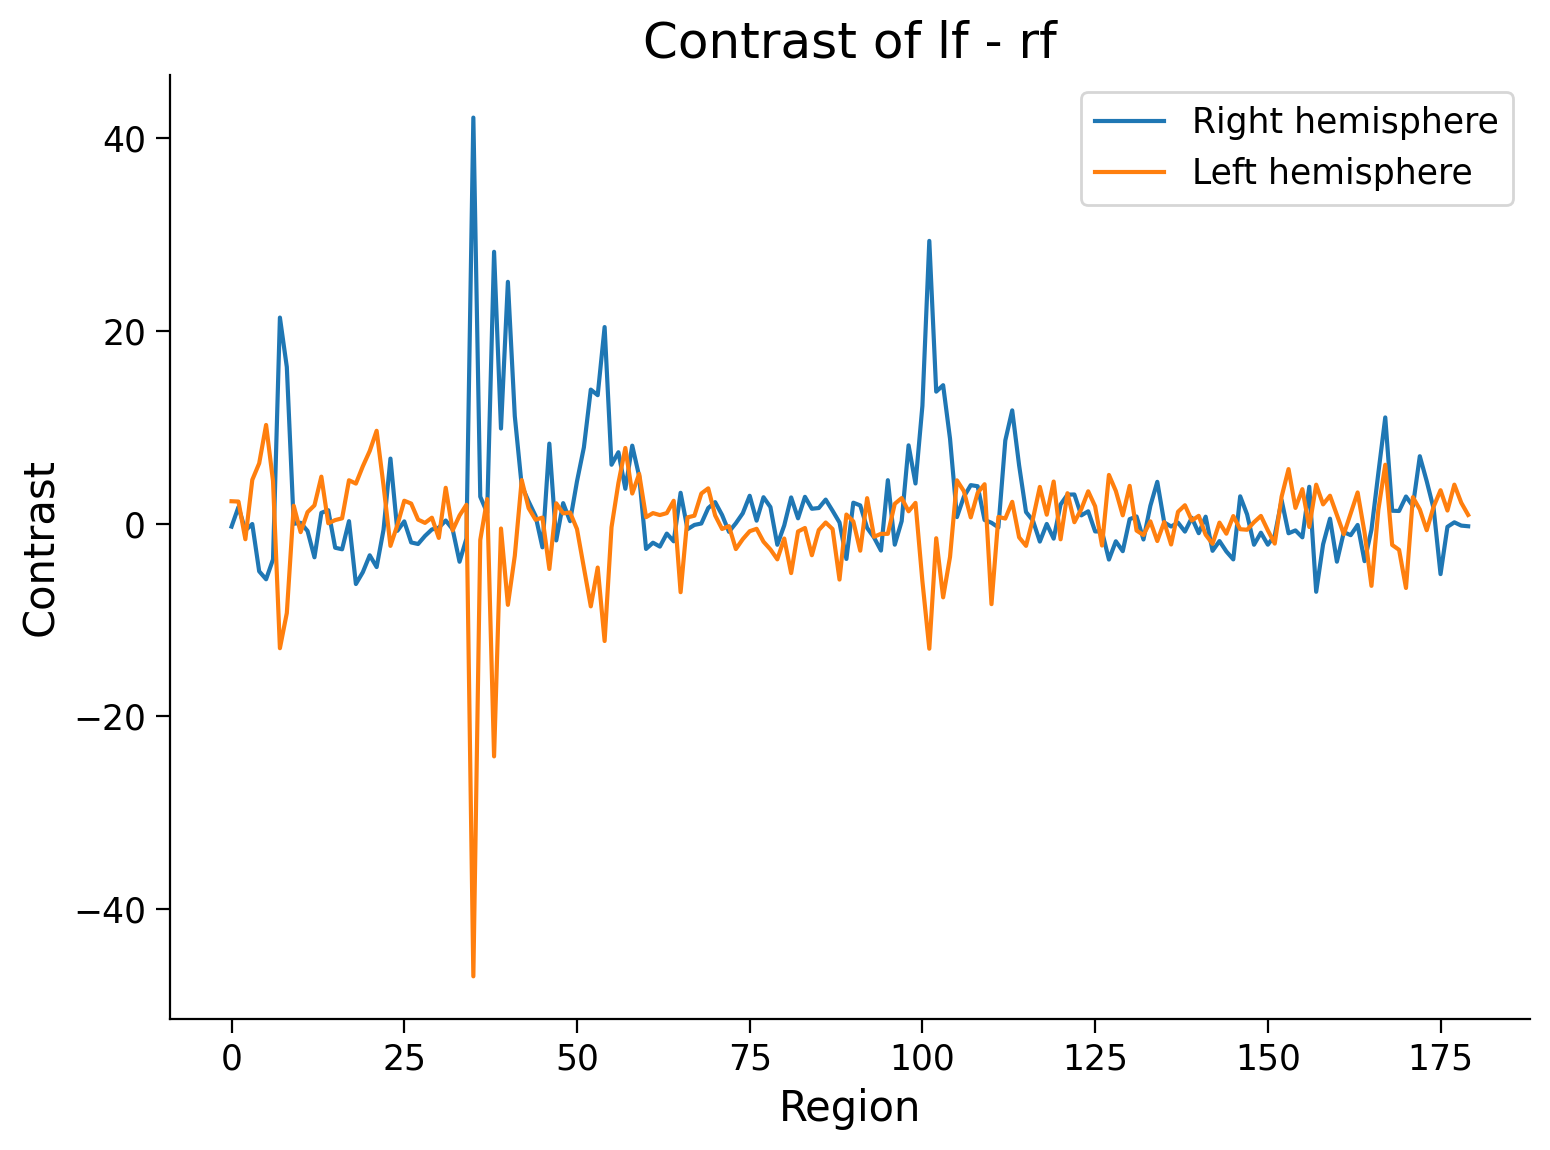

In [ ]:
hemi_contrasts = np.split(group_contrast, 2)

plt.figure()
for i, hemi_contrast in enumerate(hemi_contrasts):
  plt.plot(hemi_contrast, label=f"{HEMIS[i]} hemisphere")

plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.xlabel("Region")
plt.ylabel('Contrast')
plt.legend()
plt.show()

Plot the regional values on the surface of one hemisphere:

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'], surf_contrast, vmax=15)

## Characterize values by functional network

Average the contrast values within parcels belonging to each network and plot:

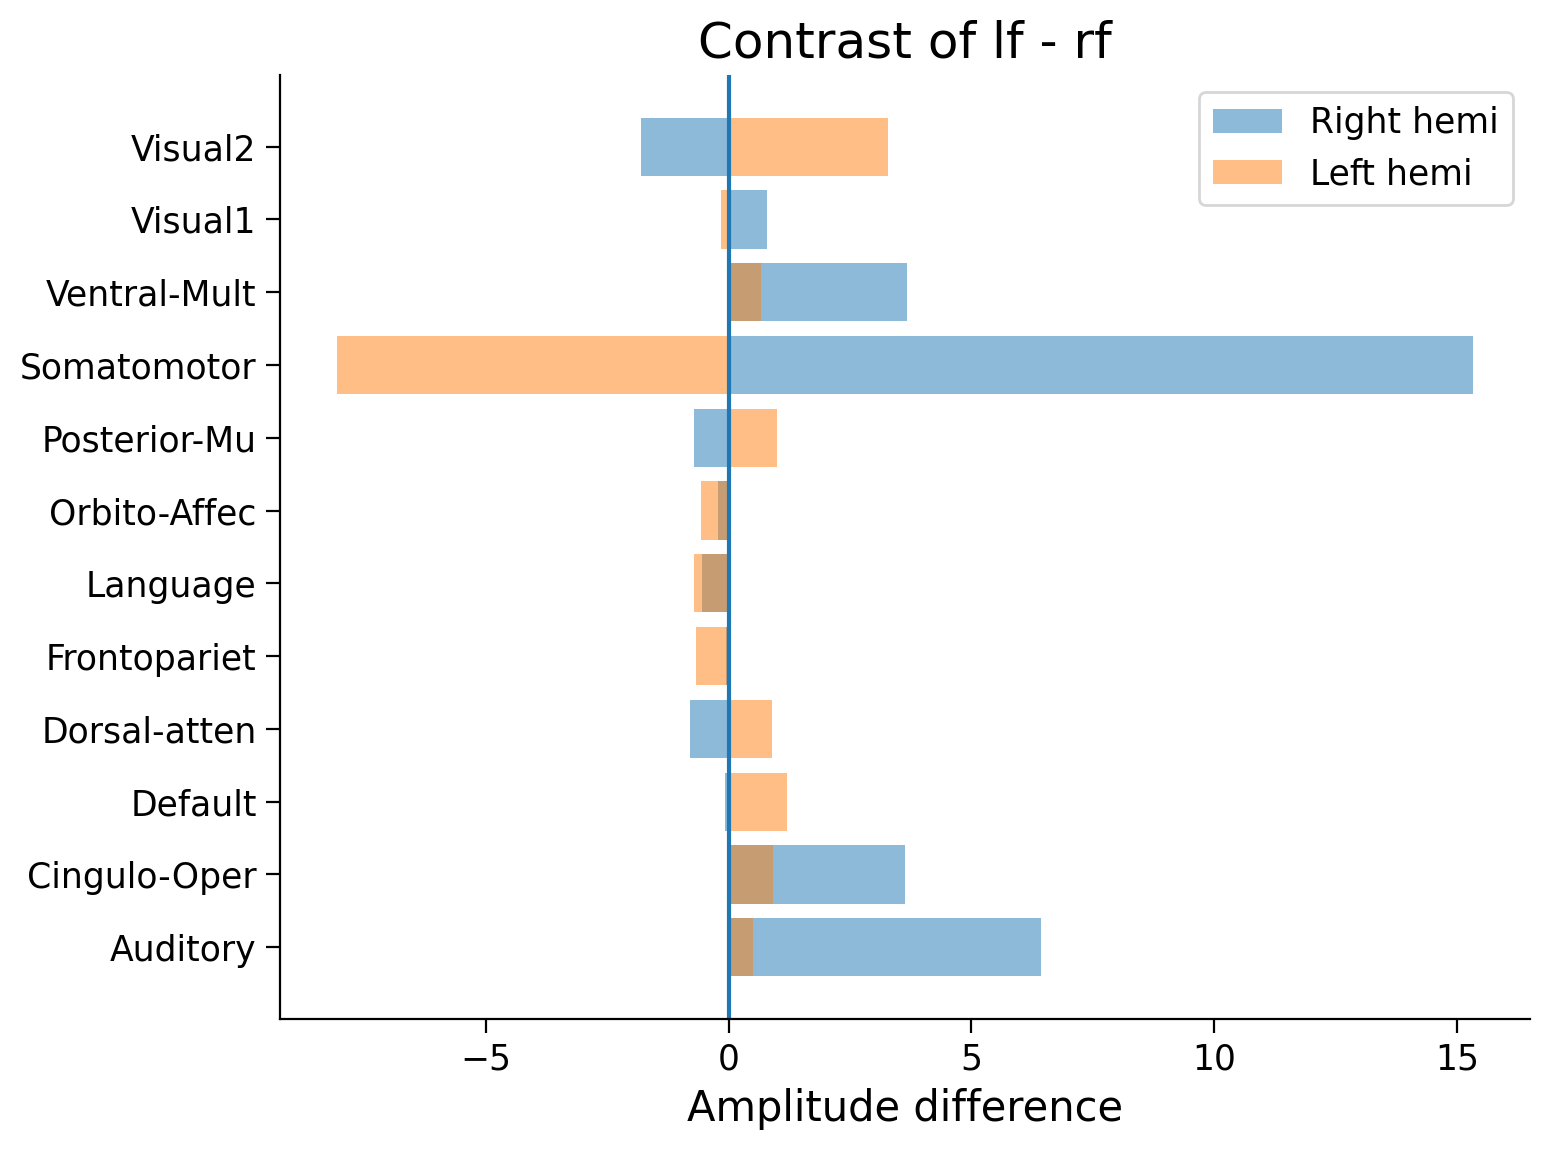

In [ ]:
# Get unique network labels
network_names = np.unique(region_info["network"])

hemi_networks = np.split(region_info["network"], 2)
hemi_contrasts = np.split(group_contrast, 2)

plt.figure()
# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals = []
  for network in network_names:
    network_vals.append(hemi_contrast[hemi_network == network].mean())
  plt.barh(network_names, network_vals, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.legend()
plt.show()

# Behavioral covariates


## Task performance measures

The dataset also includes aggregate behavior for each task run stored in task-specific `.csv` files. It is possible to load and work with these files using `numpy`:

In [ ]:
wm_behavior = np.genfromtxt(os.path.join(HCP_DIR, "hcp", "behavior", "wm.csv"),
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(wm_behavior[:5])
print(wm_behavior.dtype.names)

[(0, 0, '0BK_BODY', 1., 1., 1.,  705.5,  740.5, 696. )
 (0, 0, '0BK_FACE', 1., 1., 1.,  779.5,  765. , 915. )
 (0, 0, '0BK_PLACE', 1., 1., 1.,  926. ,  993.5, 811.5)
 (0, 0, '0BK_TOOL', 1., 1., 1.,  807.5,  807.5, 807.5)
 (0, 0, '2BK_BODY', 1., 1., 1., 1133. , 1205.5, 732.5)]
('Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET')


But, while not formally taught as part of the course, [`pandas`](https://pandas.pydata.org/) offers more powerful tools for tabular data analysis.

## Pseudo-demographics

The NMA-distributed version of the HCP data does not contain any real demographic information. But we have created a synthetic dataset of 25 "demographic" variables based on a model trained on the original dataset to predict demographics from resting-state network organization measures:

In [ ]:
demo = np.load(os.path.join(HCP_DIR, "hcp", "pseudo_demographics.npy"))
demo.shape

(339, 25)

## Original subject IDs

The dataset also contains a key to map the ordinal subject numbers to the IDs used in the original HCP dataset:

In [ ]:
ids = np.loadtxt(os.path.join(HCP_DIR, "hcp", "orig_ids.txt"))
print(ids[:8])

[199453. 580751. 173435. 919966. 181636. 192843. 894067. 174437.]
